# Importando módulos 

In [1]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,read_inventory,read_events
from obspy.io.sac.sactrace import SACTrace
from obspy.imaging.beachball import beachball,beach
from obspy.clients.fdsn import Client
from obspy.signal.trigger import recursive_sta_lta

import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal
import subprocess
from sklearn import preprocessing
import geopy.distance


#para plotar as figuras
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FixedLocator,StrMethodFormatter
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing
from matplotlib.patches import Rectangle

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import requests
import csv
import xml.etree.ElementTree as ET

# Inputs e Outputs

In [2]:
#FOLDER_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/'
#MSEED_INPUT = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/DATA_GLIDER_2024/"
#QUAKEXML_FOLDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS/'
#METADATA_FILE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/data_glider_information_csv/metadados_glider_acustico_pmpas-bs.csv'
#MODEL_CAKE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/EARTH_MODEL_AREA/model_ak135f_SOFAR.nd'
#RSBR_STATIONS = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/STA_COORD/estacoes_RSBR_costa.txt'

FOLDER_OUTPUT = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/'
MSEED_INPUT = "/home/sysop/dados_posdoc/GLIDER_PETROBRAS/DATA/"
METADATA_FILE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/data_glider_information_csv/metadados_glider_acustico_pmpas-bs.csv'
QUAKEXML_FOLDER = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS/'
MODEL_CAKE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/EARTH_MODEL_AREA/model_ak135_SOFAR.nd'
RSBR_STATIONS = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/STA_COORD/estacoes_RSBR_costa.txt'

# Extraindo informações dos arquivos ".mseed"

In [3]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*/*/GL.*'))

In [4]:
len(filenames_MSEED)

1639

In [5]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]

    st = read(i,headonly=True)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[-1].stats.endtime.datetime
    
    df = pd.DataFrame([[filename],[starttime],[endtime]], index=['filename','starttime','endtime']).T
    
    #Ending Dataframe
    #----------------------------
    return df

In [6]:
pandas_mseed_lst = []

with Pool(processes=20) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

100%|██████████████████████████████████████| 1639/1639 [00:04<00:00, 357.15it/s]


In [7]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)

In [8]:
dataframe_mseed_final['starttime'] = pd.to_datetime(dataframe_mseed_final.starttime)
dataframe_mseed_final['endtime'] = pd.to_datetime(dataframe_mseed_final.endtime)
dataframe_mseed_final['date'] = pd.to_datetime(dataframe_mseed_final.starttime).dt.date
dataframe_mseed_final.sort_values('date')

,filename,starttime,endtime,date
0,GL.G1500..HHH.D.2015.316,2015-11-12 13:48:41,2015-11-12 23:59:59.990,2015-11-12
2,GL.G1500..HHH.D.2015.317,2015-11-13 00:00:00,2015-11-13 23:48:28.930,2015-11-13
1,GL.G1500..HHH.D.2015.318,2015-11-14 01:22:11,2015-11-14 22:36:02.930,2015-11-14
3,GL.G1500..HHH.D.2015.319,2015-11-15 00:00:18,2015-11-15 21:44:28.930,2015-11-15
9,GL.G1500..HHH.D.2015.320,2015-11-16 00:11:21,2015-11-16 21:54:52.930,2015-11-16
...,...,...,...,...
1634,GL.G211E..HHH.D.2021.304,2021-10-31 00:18:55,2021-10-31 14:31:12.270,2021-10-31
1633,GL.G211E..HHH.D.2021.305,2021-11-01 05:11:58,2021-11-01 13:30:59.780,2021-11-01
1637,GL.G211E..HHH.D.2021.306,2021-11-02 02:20:51,2021-11-02 15:18:01.010,2021-11-02
1636,GL.G211E..HHH.D.2021.307,2021-11-03 03:38:04,2021-11-03 11:50:10.980,2021-11-03


# Extraindo informações do Inventório ".CSV"

In [9]:
dataframe_glider_xml = pd.read_csv(METADATA_FILE)

In [10]:
dataframe_glider_xml['time'] = pd.to_datetime(dataframe_glider_xml.time)

In [11]:
dataframe_glider_xml = dataframe_glider_xml.rename(columns={"latitude": "lat", "longitude": "lon", "depth": "dep"})

In [12]:
dataframe_glider_xml

,time,filename,lat,lon,dep
0,2015-11-12 13:48:40.999995,pa0001au_001_151112_134841_rms_spl3.mat,-23.825157,-42.495483,1.314286
1,2015-11-12 13:49:41.000001,pa0001au_001_151112_134841_rms_spl3.mat,-23.824950,-42.495487,7.415555
2,2015-11-12 13:50:40.999998,pa0001au_002_151112_135041_rms_spl3.mat,-23.824745,-42.495490,15.776000
3,2015-11-12 13:51:41.000004,pa0001au_002_151112_135041_rms_spl3.mat,-23.824540,-42.495495,24.372000
4,2015-11-12 13:52:41.000001,pa0001au_003_151112_135241_rms_spl3.mat,-23.824331,-42.495500,32.912000
...,...,...,...,...,...
547748,2021-11-04 06:52:38.000000,pa0296au_011_211104_064338_rms_spl3.mat,-24.461742,-42.471264,866.012900
547749,2021-11-04 06:53:37.999997,pa0296au_012_211104_065338_rms_spl3.mat,-24.461819,-42.471302,873.586100
547750,2021-11-04 06:54:38.000003,pa0296au_012_211104_065338_rms_spl3.mat,-24.461980,-42.471510,879.579600
547751,2021-11-04 06:55:38.000000,pa0296au_012_211104_065338_rms_spl3.mat,-24.462152,-42.471740,884.380700


# RSBR SE COAST stations:

In [13]:
RSBR_LOC = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='str')

In [14]:
kstnm = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='str',usecols=1)
stla = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='float',usecols=2)
stlo = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='float',usecols=3)
stel = np.genfromtxt(RSBR_STATIONS,skip_header=1,delimiter=';',dtype='float',usecols=4)

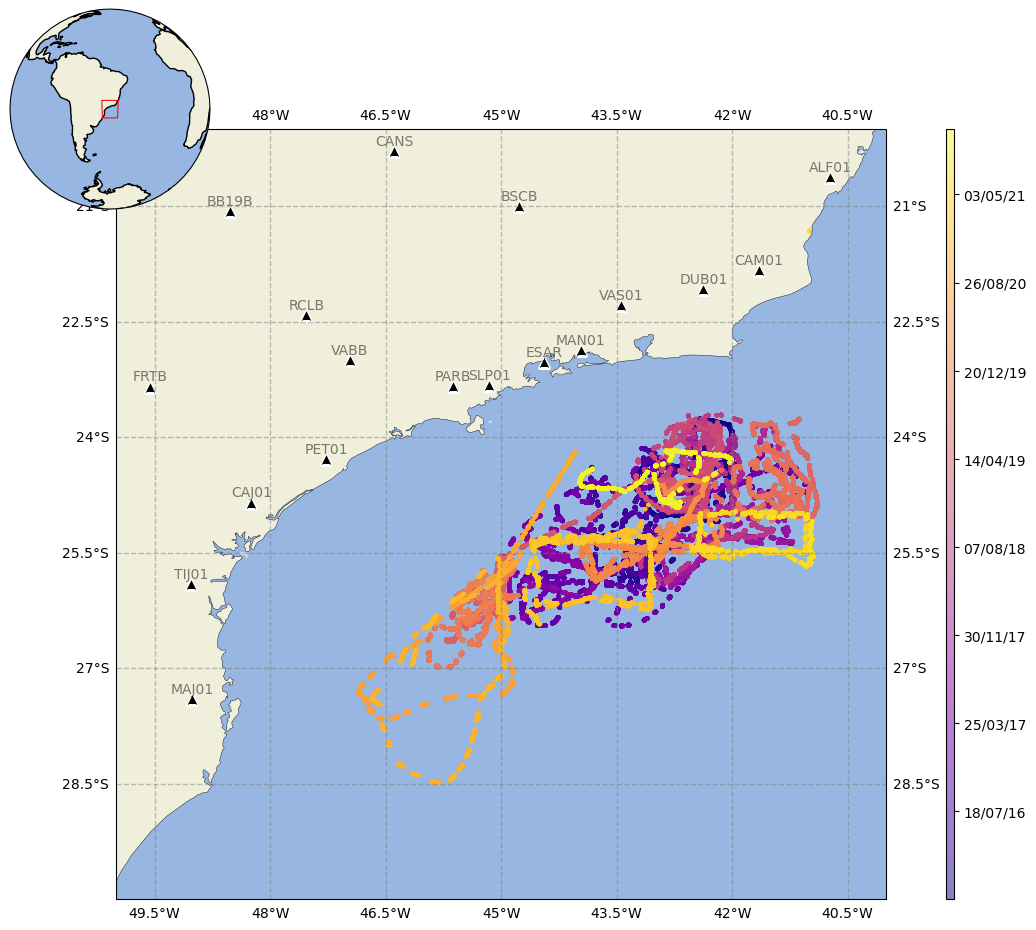

In [15]:
# Create a figure
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1,figsize=(20,10), subplot_kw=dict(projection=proj))

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-20
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values

h = ax.scatter(dataframe_glider_xml['lon'],dataframe_glider_xml['lat'],c=np.array([mdates.date2num(i) for i in dataframe_glider_xml['time']]),marker='.',alpha=0.5,cmap='plasma',s=20,transform=proj)
ax.scatter(stlo,stla,c='k',marker='^',ec='w',s=70,transform=proj)

# Use the cartopy interface to create a matplotlib transform object
# for the Geodetic coordinate system. We will use this along with
# matplotlib's offset_copy function to define a coordinate system which
# translates the text by 25 pixels to the left.
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', x=0,y=10)

for lo,la,name in zip(stlo,stla,kstnm):
    if lo < lonmax and lo > lonmin and la > latmin and la < latmax:
        ax.text(lo,la,s=name, verticalalignment='center', horizontalalignment='center',alpha=0.5,transform=text_transform)
  
# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

#####################################################
# Adding inset axes LEFT
#####################################################

# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# Adding Geoaxes
ax_map = plt.axes([0.2, 0.8, 0.2, 0.2], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax_map.set_global()

# Adding background map 
ax_map.add_feature(cfeature.LAND)
ax_map.add_feature(cfeature.OCEAN)
ax_map.add_feature(cfeature.COASTLINE)

# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax_map.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.75)


# Buscando eventos com mecanismos focais através do pyGCMT

In [39]:
cat = obspy.read_events(QUAKEXML_FOLDER+'CMTSOLUTIONS*')
cat

781 Event(s) in Catalog:
2021-12-29T18:26:00.000000Z |  -7.690, +127.560 | 7.32 mw
2021-12-26T15:43:01.700000Z | -18.060, -179.360 | 6.14 mw
...
2015-11-07T07:04:41.800000Z | -29.540,  -72.330 | 6.05 mw
2015-11-04T03:44:21.200000Z |  -8.200, +124.950 | 6.54 mw
To see all events call 'print(CatalogObject.__str__(print_all=True))'

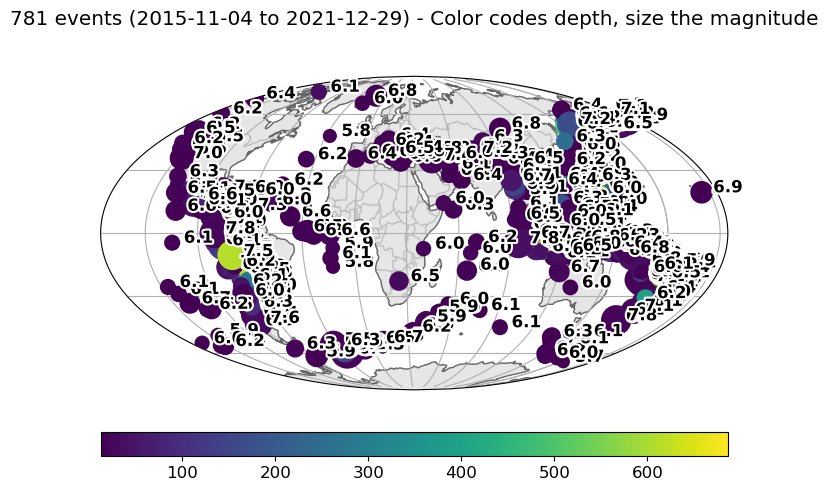

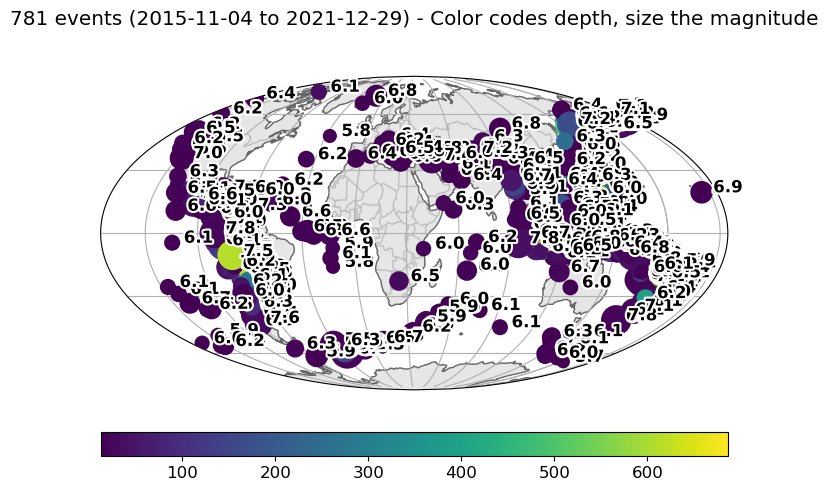

In [40]:
cat.plot()

# PROCURANDO EVENTOS EM FUNÇÃO DO CATÁLOGO 

In [41]:
def energy_ratio(a, nsta):
    """
    Energy ratio detector.

    Energy ratio defined as

    .. math::
        \text{er}(i) = \frac{\sum_{j=i}^{i+L}{a_j^2}}{\sum_{j=i-L}^{i}{a_j^2}}

    where :math:`L` is ``nsta``.

    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of the energy ratio window in samples. It's the same
                 length as ``nsta`` in the classical STA/LTA methods.
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Energy Ratio

    .. seealso:: [Han2009]_
    """
    if nsta > len(a) // 2:
        # Half forward, half backward -> empty medium
        msg = (
            f'nsta ({nsta}) must not be larger than half the length of the '
            f'data ({len(a)} samples).')
        raise ValueError(msg)
    if nsta <= 0:
        # If nsta is zero, the sum is undefined
        msg = f'nsta ({nsta}) must not be equal to or less than zero.'
        raise ValueError(msg)
    sig_power = np.r_[0, np.cumsum(a ** 2, dtype=np.float64)]
    energy_diff = sig_power[nsta:] - sig_power[:len(sig_power) - nsta]
    er = np.zeros(len(a), dtype=np.float64)
    np.divide(energy_diff[nsta:], energy_diff[:len(energy_diff) - nsta],
              where=energy_diff[:len(energy_diff) - nsta] != 0,
              out=er[nsta:len(er) - nsta + 1])
    return er


def modified_energy_ratio(a, nsta, power=3):
    r"""
    Modified energy ratio detector.

    Improvement of the :func:`energy_ratio` that accounts for the signal
    itself:

    .. math::
        \text{mer}(i) = (\text{er}(i) * |a(i)|)^3

    where :math:`text{er}(i)` is the :func:`energy_ratio`.

    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of energy ratio window in samples. It's the same length
                 as ``nsta`` in the classical STA/LTA methods.
    :type power: int
    :param power: The power exponent in the equation above. Default: 3
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Modified Energy Ratio
    """
    er = energy_ratio(a, nsta=nsta)
    mer = np.power(er * np.abs(a), power, out=er)
    return mer

In [42]:
def nearest_date(collum,pivot):
    '''
    To find a closest date
    '''
    min_id = (collum - pivot).abs().idxmin()

    return min_id

In [43]:
# Função de filtro para a condição especificada
def condition(lst):
    valid_last_elements = [True, False]
    return (lst[0] == False and 
            lst[1] == False and 
            lst[2] == False and 
            (lst[3] in valid_last_elements and lst[4] == True or lst[3] == True and lst[4] in valid_last_elements))

In [44]:
def event_search(inpt,CUT_BEFORE=-120,CUT_AFTER=300,FREQ_CFT=3,STA_short=2,LTA_short=30,THRON=3,THROFF=1.5,SNR_MIN=1.5,event_cut_sta_lta_band=30,nl_start=8,nl_end=22,sl_start=7,sl_end=7,time_sta_lta_ls=10,model_earth='ak135'):
        '''
        Function to search and plot events
        
        CUT_BEFORE:
        CUT_AFTER:,
        FREQ_CFT:,
        STA_short:,
        LTA_short,
        THRON:,
        event_cut_sta_lta_band:,
        nl_start:, 
        nl_end:,
        sl_start:,
        sl_end:,
        model_earth:
        ''' 

        ev_file = inpt[0]
        seismic_phase = inpt[1]
    
        # =========================================
        # CODE
        
        # Setting: Global font size
        mpl.rcParams.update({'font.size': 12})

        # -------------------------------------------------------------------------------------
        # Event catalog (https://docs.obspy.org/packages/autogen/obspy.core.event.Catalog.html)
        # -------------------------------------------------------------------------------------

        ev = ev_file
        
        ev_time = ev.origins[0].time
        
        ev_lat = ev.origins[0].latitude
        ev_long = ev.origins[0].longitude
        ev_depth = ev.origins[0].depth/1000
           
        # ###################################################################################################### #
        # ###################################################################################################### #
        # ###################################################################################################### #   
        # Initial stage: Is there an mseed file available for event time window (until 1 hour after event time)? #
        # ###################################################################################################### #    
        # ###################################################################################################### #   
        # ###################################################################################################### #
        
        ev_time_d = pd.to_datetime(ev_time.datetime) # To ensure that a value is a datetime object in pandas
        ev_time_final = ev_time+pd.Timedelta(hours=1)

        # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # Location information: Is there location data for the glider on the selected event time window (until 1 hour after event time)?
        # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

        inv_glider_day = dataframe_glider_xml[(dataframe_glider_xml['time'] >= ev_time_d) & (dataframe_glider_xml['time'] <= (ev_time_d+pd.Timedelta(hours=1)))]

        if len(inv_glider_day) > 1:
                #yes

                lat_glider = inv_glider_day.lat.values.mean()
                lon_glider = inv_glider_day.lon.values.mean()
                dep_glider = -abs(inv_glider_day.dep.values.mean())
                time_glider = inv_glider_day.time.values[int(len(inv_glider_day)/2)]

                # -----------------------------------------------------------------
                # Estimation: distance, azimuth and backazimuth (https://docs.obspy.org/packages/autogen/obspy.geodetics.base.gps2dist_azimuth.html)

                dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,lat_glider,lon_glider)
                gcarc = obspy.geodetics.kilometer2degrees(dist/1000)

                # -----------------------------------------------------------------
                # Estimation: arrival time by CAKE (https://pyrocko.org/docs/current/apps/cake/index.html)
                # Cake is a command line tool contained in Pyrocko, which can solve some classical seismic ray theory problems for 1D layered earth models (layer cake models).
                    
                command = 'cake arrivals --model='+MODEL_CAKE+' --sdepth='+str(ev_depth)+' --rdepth='+str(np.abs(dep_glider)/1000)+' --distances='+str(gcarc)+' --degrees --classic='+seismic_phase
                proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
                (out, err) = proc.communicate()
                results = out.splitlines()

                # ############################################################################ #
                # Cake: expected result for first arrival (P, PKIKP, PKP):
                    
                # slow    dist  time   take inci effi spre phase             used
                # s/km    km    s      deg  deg  %    %
                # ----------------------------------------------------------------------------
                # 0.09711 10.00 2.3147  128 10.6 58.7  103 p                 (p)
                # ############################################################################ #

                # Is there an arrival time for this specific seismic phase?
                if len(results) > 3:
                    # yes

                    event = ev_time+float(results[3].split(' ')[2])
                    event = pd.to_datetime(event.datetime)
    
                    P_label = seismic_phase
                        
                    # #################################################################################################### #
                    # #################################################################################################### #
                    # #################################################################################################### #   
                    # Refine stage: Is there an mseed file available for event time window (ev_time + phase arrival time)? #
                    # #################################################################################################### #    
                    # #################################################################################################### #   
                    # #################################################################################################### #   

                    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                    # Location information: Is there location data for the glider on the selected event time window (ev_time + phase arrival time)?
                    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
            
                    inv_glider_day = dataframe_glider_xml.loc[(pd.to_datetime(dataframe_glider_xml['time'])-event).abs().idxmin()]
                    
                    # ++++++++++++++++++++++++++++ #
                    # ++++++++++++++++++++++++++++ #
                    # Refine: Compute new distance #
                    # ++++++++++++++++++++++++++++ #
                    # ++++++++++++++++++++++++++++ #
            
                    lat_glider = inv_glider_day.lat
                    lon_glider = inv_glider_day.lon
                    dep_glider = -abs(inv_glider_day.dep)
                    time_glider = inv_glider_day.time
    
                    # ----------------------------------------------------------------------------------------------------------------------------------
                    # Estimation: distance, azimuth and backazimuth (https://docs.obspy.org/packages/autogen/obspy.geodetics.base.gps2dist_azimuth.html)
    
                    dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,lat_glider,lon_glider)
                    gcarc = obspy.geodetics.kilometer2degrees(dist/1000)
                    
                    # ++++++++++++++++++++++++++++++++++++++ #
                    # ++++++++++++++++++++++++++++++++++++++ #
                    # Refine: Compute new phase arrival time #
                    # ++++++++++++++++++++++++++++++++++++++ #
                    # ++++++++++++++++++++++++++++++++++++++ #
                    
                    # -------------------------------------------------------------------------------------------------------------------------------------------------------------
                    # Estimation: arrival time by CAKE (https://pyrocko.org/docs/current/apps/cake/index.html)
                    # Cake is a command line tool contained in Pyrocko, which can solve some classical seismic ray theory problems for 1D layered earth models (layer cake models).
                        
                    command = 'cake arrivals --model='+MODEL_CAKE+' --sdepth='+str(ev_depth)+' --rdepth='+str(np.abs(dep_glider)/1000)+' --distances='+str(gcarc)+' --degrees --classic='+seismic_phase
                    proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
                    (out, err) = proc.communicate()
                    results = out.splitlines()

                    # ++++++++++++++++++++++++++++++ #
                    # ++++++++++++++++++++++++++++++ #
                    # Refine: Compute new event time #
                    # ++++++++++++++++++++++++++++++ #
                    # ++++++++++++++++++++++++++++++ #
                    
                    if len(results) > 3:
                        # yes
                        
                        event = ev_time+float(results[3].split(' ')[2])

                        file_mseed_event = dataframe_mseed_final[(dataframe_mseed_final.date == ev_time_d.date())]

                        if len(file_mseed_event) > 0:
                            
                            name_glider = file_mseed_event['filename'].tolist()[0].split('.')[1]

                            ev_file_mseed = file_mseed_event['filename'].tolist()[0]
                            file_mseed_ev = sorted(glob.glob(MSEED_INPUT+'*/*/*/*/'+ev_file_mseed+'*'))[0]

                            # Cut all traces of this Stream object to given start (event date+CUT_BEFORE) and end time (event date+CUT_AFTER).
                            stream_mseed = read(file_mseed_ev,starttime=event+CUT_BEFORE,endtime=event+CUT_AFTER)
                            stream_mseed.merge(method=1,fill_value='interpolate')
                            
                            # +++++++++++++++ #
                            # +++++++++++++++ #
                            # Event detection #
                            # +++++++++++++++ #
                            # +++++++++++++++ #
                        
                            # Cut all traces of this Stream object around first wave arrival (event date-event_cut_sta_lta_band) and end time (event date+event_cut_sta_lta_band).
                            stream_mseed_around_P_wave_arrival = stream_mseed.copy()

                            if len(stream_mseed_around_P_wave_arrival.trim(event-event_cut_sta_lta_band,event+event_cut_sta_lta_band)) > 0:
                                # yes
                                
                                # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
                                # Plotting glider location: Is there a glider data (location) available (until 1 hour before and after event time)? 
                                # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
  
                                name_glider_df_sel = dataframe_glider_xml[(dataframe_glider_xml.time >= pd.to_datetime(event.datetime)-pd.Timedelta(hours=1)) & (dataframe_glider_xml.time <= pd.to_datetime(event.datetime)+pd.Timedelta(hours=1))]
                                
                                if len(name_glider_df_sel) > 0:
                                    # yes
                                    lat_event_info = name_glider_df_sel.lat.to_list() 
                                    lon_event_info = name_glider_df_sel.lon.to_list()          
                                    depth_event_info = [-abs(i) for i in name_glider_df_sel.dep.to_list()]       
                                    time_event_info = [i for i in name_glider_df_sel.time.to_list()]  

                                    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                                    # Saving: sac file trace (starttime: event+CUT_BEFORE & endtime: event+CUT_AFTER)
                                    
                                    headerHHH = {
                                                'kstnm': name_glider, 'kcmpnm': 'HHH','knetwk':'GL',
                                                'stla': float(lat_glider), 'stlo': float(lon_glider),'stel': float(dep_glider),
                                                'evdp': float(ev_depth), 'evla': float(ev_lat), 'evlo': float(ev_long), 'mag': float(ev.magnitudes[0].mag),
                                                'nzhour': int(stream_mseed[0].stats.starttime.hour),'nzjday': int(stream_mseed[0].stats.starttime.julday), 'nzmin': int(stream_mseed[0].stats.starttime.minute), 'nzmsec': int('{:03}'.format(stream_mseed[0].stats.starttime.microsecond)[:3]),'nzsec': int(stream_mseed[0].stats.starttime.second),'nzyear': int(stream_mseed[0].stats.starttime.year),
                                                'cmpaz': 0.0, 'cmpinc': 0.0, 'dist': float(dist/1000), 'gcarc': float(gcarc), 'az': float(az), 'baz': float(baz),
                                                'o':float(results[3].split(' ')[2]),'delta':stream_mseed[0].stats.delta
                                                }
                                    
                                    sacHHH = SACTrace(data=stream_mseed[0].data, **headerHHH)
        
                                    # Creating glider output directory:
                                    output_sac_data = FOLDER_OUTPUT+'EVENTS_GLIDERS/'+'GL'+'/'+name_glider+'/'+'{:04}'.format(ev_time.year)+'/'+'{:03}'.format(ev_time.julday)+'/'+'{:04}'.format(ev_time.year)+'.'+'{:03}'.format(ev_time.julday)+'.'+'{:02}'.format(ev_time.hour)+'.'+'{:02}'.format(ev_time.minute)+'.'+'{:02}'.format(ev_time.second)+'.'+'{:02}'.format(ev_time.microsecond)[:3]+'/'
                                    os.makedirs(output_sac_data,exist_ok=True)
                                    sacHHH.write(output_sac_data+'GL'+'.'+name_glider+'.'+'{:04}'.format(ev_time.year)+'.'+'{:03}'.format(ev_time.julday)+'.'+'{:02}'.format(ev_time.hour)+'.'+'{:02}'.format(ev_time.minute)+'.'+'{:02}'.format(ev_time.second)+'.'+'{:02}'.format(ev_time.microsecond)[:3]+'.H')
                                    
                                    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

                                    # Analysing the event (plotting and estimating parameters) 
                                    
                                    # ----------------------------------------------------------------------------------------------------------
                                    # set up the plot and create a GeoAxes:
                                    # ----------------------------------------------------------------------------------------------------------
    
                                    proj = ccrs.PlateCarree()
        
                                    fig = plt.figure(constrained_layout=True,figsize=(20,15))
                                    
                                    spec2 = gridspec.GridSpec(ncols=3, nrows=9, figure=fig)
                                    ax = fig.add_subplot(spec2[0:3,:], projection=proj)
                                    ax1 = fig.add_subplot(spec2[3:6,0])
                                    ax2 = fig.add_subplot(spec2[6:9,0],sharex=ax1)
        
                                    # ----------------------------------------------------------------------------------------------------------
                                    # Limit the extent of the map to a small longitude/latitude range (Southeast Brazil region)
                                    # ----------------------------------------------------------------------------------------------------------
        
                                    latmin=-28.5
                                    latmax=-22.5
                                    lonmin=-50
                                    lonmax=-40
        
                                    ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())
        
                                    # ---------------------------------------------------------------------------------------------------------------------------------------------------
                                    # Plotting latitude, longitude, and depth (glider's trajectory, glider location, and coastal stations) [https://scitools.org.uk/cartopy/docs/latest/]
                                    # ---------------------------------------------------------------------------------------------------------------------------------------------------
        
                                    h = ax.scatter(dataframe_glider_xml['lon'],dataframe_glider_xml['lat'],c=np.array([mdates.date2num(i) for i in dataframe_glider_xml['time']]),marker='o',alpha=0.5,cmap='plasma',s=25,transform=proj)
                                    ax.scatter(lon_glider, lat_glider, color='r',marker='o',s=100,ec='k',transform=proj)
        
                                    ax.scatter(stlo,stla,c='k',marker='^',ec='w',s=70,transform=proj)
                                    
                                    # Use the Cartopy interface to create a Matplotlib transform object
                                    # for the Geodetic coordinate system. We will use this along with
                                    # Matplotlib's offset_copy function to define a coordinate system
                                    # that translates the text 10 pixels upward.
                                    
                                    geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
                                    text_transform = offset_copy(geodetic_transform, units='dots', x=0,y=10)
                                    
                                    # Add text 10 pixels upward.
                                    for lo,la,name in zip(stlo,stla,kstnm):
                                        if lo < lonmax and lo > lonmin and la > latmin and la < latmax:
                                            ax.text(lo,la,s=name, verticalalignment='center', horizontalalignment='center',alpha=0.5,transform=text_transform)
                                    
                                    # ---------------------
                                    # Adding background map 
                                    
                                    ax.add_feature(cfeature.LAND)
                                    ax.add_feature(cfeature.OCEAN)
                                    ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
                                    ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
                                    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
        
                                    # Title
                                    ax.set_title(ev.origins[0].time.strftime('%Y-%m-%dT%H:%M:%S')+'\n Dist: '+str(round(gcarc))+'$^\circ$'+' Dep: '+str(round(ev_depth))+' km'+'\n Mag: '+str(ev.magnitudes[0].mag)+' '+ev.magnitudes[0].magnitude_type+'\n ',y=1.02,fontsize=20)
        
                                    # ----------------
                                    # Adding colorbar
        
                                    divider = make_axes_locatable(ax)
                                    ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)
        
                                    fig.add_axes(ax_cb)
                                    cb = plt.colorbar(h, cax=ax_cb)
                                    cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
        
                                    # ================================
                                    # Adding inset: LATITUDE-LONGITUDE
                                    # ================================
        
                                    axins = plt.axes([0.8, 0.70, 0.15, 0.15],projection=proj)
                                    axins.scatter(lon_event_info,lat_event_info,c=np.array([mdates.date2num(i) for i in time_event_info]),marker='o',cmap='plasma',s=100,transform=proj,vmax=max([mdates.date2num(i) for i in dataframe_glider_xml['time']]),vmin=min([mdates.date2num(i) for i in dataframe_glider_xml['time']]))
                                    axins.scatter(lon_glider, lat_glider, color="none",marker='o',s=100,ec='k',lw=2,transform=proj)
                                    axins.set_title("Lat: "+str(round(lat_glider,2))+'$^\circ$ | '+"Lon: "+str(round(lon_glider,2))+'$^\circ$',fontsize=13)

                                    # ---------------------
                                    # Adding background map 
                                    
                                    axins.add_feature(cfeature.LAND)
                                    axins.add_feature(cfeature.OCEAN)
                                    axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
                                    axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
        
                                    # ----------------------------------------------------------------------------------------------------------
                                    # Adding grid
        
                                    axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                                    axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)

                                    # --------------------------------
                                    # subregion of the original image 
                                    
                                    x1 = np.min(lon_event_info)-abs(np.min(lon_event_info)/90)
                                    x2 = np.max(lon_event_info)+abs(np.max(lon_event_info)/90)
                                    y1 = np.min(lat_event_info)-abs(np.min(lat_event_info)/90)
                                    y2 = np.max(lat_event_info)+abs(np.max(lat_event_info)/90)
                                    axins.set_xlim(x1, x2)
                                    axins.set_ylim(y1, y2)
                                    ax.indicate_inset_zoom(axins, edgecolor="black")
        
                                    # =============================
                                    # Adding inset: DEPTH-LONGITUDE
                                    # =============================
        
                                    ax_histx = plt.axes([0.8, 0.86, 0.15, 0.05],sharex=axins,facecolor='lightsteelblue')
                                    ax_histx.scatter(lon_event_info,depth_event_info, c=np.array(mdates.date2num(time_event_info)),marker='o',vmax=max([mdates.date2num(i) for i in dataframe_mseed_final['starttime']]),vmin=min([mdates.date2num(i) for i in dataframe_mseed_final['starttime']]),alpha=0.5,cmap='plasma',s=100)
                                    ax_histx.scatter(lon_glider,dep_glider, c="none",marker='o',ec='k',lw=2,s=100)
                                    ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                                    ax_histx.set_title("Depth: "+str(round(dep_glider))+' m',fontsize=13)
                                    ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
                                    ax_histx.set_ylim(-1000,0)
                                    ax_histx.yaxis.set_major_formatter('{x} m')
                                    ax_histx.yaxis.set_major_locator(MultipleLocator(500))
                                    ax_histx.yaxis.set_minor_locator(MultipleLocator(100))
        
                                    # ==========================
                                    # Adding global location map
                                    # ==========================
                                    
                                    # --------------
                                    # Adding Geoaxes
                                    
                                    ax_map = plt.axes([0.25, 0.85, 0.13, 0.13], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
                                    ax_map.set_global()

                                    # ---------------------
                                    # Adding background map 

                                    ax_map.add_feature(cfeature.LAND)
                                    ax_map.add_feature(cfeature.OCEAN)
                                    ax_map.add_feature(cfeature.COASTLINE)

                                    # -----------------------------
                                    # Adding red rectangle position
                                    
                                    nvert = 100
                                    lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                                         np.linspace(lonmin, lonmax, nvert),
                                                         np.linspace(lonmax, lonmax, nvert)].tolist()
                                    lats = np.r_[np.linspace(latmin, latmax, nvert),
                                                         np.linspace(latmax, latmax, nvert),
                                                         np.linspace(latmax, latmin, nvert)].tolist()
        
                                    ring = LinearRing(list(zip(lons, lats)))
                                    
                                    # ------------------------------------------------------------------
                                    # Plotting: rectangle position and event-station (path and location)
                                    
                                    ax_map.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)
                                    ax_map.scatter(ev_long,ev_lat,color="y",marker='*',s=200,ec='k',transform=ccrs.PlateCarree())
                                    ax_map.scatter(np.mean(lon_event_info),np.mean(lat_event_info),color="r",marker='^',s=50,transform=ccrs.PlateCarree())
                                    ax_map.plot([np.mean(lon_event_info), ev_long], [np.mean(lat_event_info), ev_lat], c='gray',ls='-',lw=2, transform=ccrs.Geodetic())
        
                                    # ===========================================================================================
                                    # Adding a trace plot (high (st_HF) and low (st_LF) frequency filtered data in the same axes)
                                    # ===========================================================================================

                                    # -----------------
                                    # Duplicating axes:
                                    
                                    ax1_HF = ax1.twinx()

                                    # ---------------------
                                    # Retrieving trace data
        
                                    st_LF = stream_mseed.copy()
                                    st_HF = stream_mseed.copy()

                                    # ---------------------------------------------------
                                    # Computing & Plotting: High frequency lowpassed data
                                    
                                    for tr in st_HF:
                                        tr.detrend("linear")
                                        tr.taper(max_percentage=0.05, type='cosine')
                                        tr.filter('highpass', freq=FREQ_CFT, corners=4, zerophase=True)
                                        line_HF, = ax1_HF.plot(tr.times('matplotlib'), tr.data,'grey', lw=2,alpha=0.5,label='> '+str(FREQ_CFT)+' Hz')
                                    ax1_HF.legend(handles=[line_HF],loc='lower right', fontsize=10, edgecolor='grey', labelcolor='grey')   

                                    # --------------------------------------------------
                                    # Computing & Plotting: Low frequency lowpassed data
                                    
                                    for tr in st_LF:
                                        tr.detrend("linear")
                                        tr.taper(max_percentage=0.05, type='cosine')
                                        tr.filter('lowpass', freq=FREQ_CFT, corners=4, zerophase=True)
                                        line_LF, = ax1.plot(tr.times('matplotlib'), tr.data,'k', lw=1, label='< '+str(FREQ_CFT)+' Hz')
                                    ax1.legend(handles=[line_LF],loc='lower left', fontsize=10, edgecolor='k', labelcolor='k')

                                    # ---------------------------------------------
                                    # Plotting: First wave arrival (line and label)
                                    
                                    ax1.text(x=event.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s=P_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                    ax1.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')

                                    # -------------------------
                                    # Plotting: axes parameters 
                                    
                                    ax1.set_ylabel('Amplitude [units]')
                                    ax1.set_ylim(-1.5*abs(np.max(st_LF[0].data)),1.5*abs(np.max(st_LF[0].data)))
                                    ax1.set_xlim(st_LF[0].times('matplotlib')[0],st_LF[0].times('matplotlib')[-1])
                                    
                                    # DateLocator: interval 2 min
                                    locator = mdates.MinuteLocator(interval=2)
                                    ax1.xaxis.set_major_locator(locator)
                                    locatormin = mdates.MinuteLocator(interval=1)
                                    ax1.xaxis.set_minor_locator(locatormin)
                                    
                                    # DateFormatter: interval 2 min
                                    formatter = mdates.DateFormatter('%H:%M:%S')
                                    ax1.xaxis.set_major_formatter(formatter)
                    
                                    ax1.set_title('Station: '+name_glider)
        
                                    ax1_HF.set_ylim(-1.5*abs(np.max(st_HF[0].data)),1.5*abs(np.max(st_HF[0].data)))
                                    ax1_HF.set_xlim(st_HF[0].times('matplotlib')[0],st_HF[0].times('matplotlib')[-1])
                                
                                    ax1.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=False,labelbottom=False, labeltop=False, labelleft=True, labelright=False)
                                    ax1_HF.tick_params(axis='both',which="both",bottom=False, top=False, left=False, right=True,labelbottom=False, labeltop=False, labelleft=False, labelright=True,labelcolor='grey')
     
                                    ax1.spines['top'].set_linewidth(2)
                                    ax1.spines['right'].set_linewidth(2)
                                    ax1.spines['bottom'].set_linewidth(2)
                                    ax1.spines['left'].set_linewidth(2)
                                    ax1.xaxis.set_tick_params(width=2)
                                    ax1.yaxis.set_tick_params(width=2)      
                                    
                                    # ============================================================================================================================================
                                    # Adding spectrogram plot [Power spectral density] (https://docs.scipy.org/doc/scipy-1.13.1/reference/generated/scipy.signal.spectrogram.html)
                                    # ============================================================================================================================================

                                    # -----------------------------------------------------------
                                    # Computing: Spectrogram with consecutive Fourier transforms 

                                    fs = stream_mseed[0].stats.sampling_rate  # Sampling rate (samples per second)
                                    signal_data = stream_mseed[0].data

                                    # ---------------------------------------------------------------------
                                    # Spectrogram (Power spectral ‘density’ where Sxx has units of V**2/Hz)
                                    
                                    frequencies, times, Sxx = signal.spectrogram(x=signal_data, fs=fs,nperseg=128,scaling='density')

                                    # -------------------------------------------------------------------------------------------------------------------
                                    # Plotting: Spectrogram (https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html)
                                    
                                    im = ax2.imshow(10 * np.log10(Sxx),extent=[st_HF[0].times('matplotlib')[0],st_HF[0].times('matplotlib')[-1], 0, fs/2],aspect='auto',origin='lower',cmap='magma',interpolation='kaiser',vmin=50,vmax=150)

                                    # -------------------------
                                    # Plotting: axes parameters 

                                    ax2.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)
                                    ax2.xaxis.set_major_locator(locator)
                                    ax2.xaxis.set_minor_locator(locatormin)
                                    ax2.xaxis.set_major_formatter(formatter)
                                    ax2.spines['top'].set_linewidth(2)
                                    ax2.spines['right'].set_linewidth(2)
                                    ax2.spines['bottom'].set_linewidth(2)
                                    ax2.spines['left'].set_linewidth(2)
                                    ax2.xaxis.set_tick_params(width=2)
                                    ax2.yaxis.set_tick_params(width=2)  
                                    ax2.set_ylabel('Frequency [Hz]')

                                    # ---------------------------------------------
                                    # Plotting: First wave arrival (line and label)
                                                                        
                                    ax2.text(x=event.matplotlib_date,y=45,s=P_label,ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                                    ax2.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='w',linestyle='--')
        
                                    # ----------------------------------------------------------------------------------------------
                                    # Plotting: Colorbar (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html)
        
                                    ax_cbar = inset_axes(ax2,
                                                                width="20%",  # width = 15% of parent_bbox width
                                                                height="3%",  # height : 3%
                                                                loc='upper right',
                                                                bbox_to_anchor=(-0.1, -0.1, 1, 1),
                                                                bbox_transform=ax2.transAxes,
                                                                borderpad=0.1
                                                                )

                                    cbar = fig.colorbar(im, cax=ax_cbar, orientation="horizontal")
                                    cbar.ax.xaxis.set_ticks_position('top')
                                    cbar.ax.xaxis.set_label_position('bottom')
                                    cbar.set_label('PSD (dB unit²/Hz)')
                                    cbar.outline.set_linewidth(2)
        
                                    # ===================================================================================
                                    # focal mechanism (https://docs.obspy.org/tutorial/code_snippets/beachball_plot.html)
                                    # ===================================================================================
                                    
                                    # ---------------------------
                                    # Plotting: adding a new axes
                                    
                                    newax = fig.add_axes([0.05, 0.53, 0.25,  0.25])
                                    
                                    # -----------------------------------------
                                    # Computing: Retrieving moment tensor info
                                            
                                    moment_tensor = ev.focal_mechanisms[0].moment_tensor
                                    mrr = moment_tensor.tensor.m_rr
                                    mtt = moment_tensor.tensor.m_tt
                                    mpp = moment_tensor.tensor.m_pp
                                    mrt = moment_tensor.tensor.m_rt
                                    mrp = moment_tensor.tensor.m_rp
                                    mtp = moment_tensor.tensor.m_tp
                                    mt = [mrr, mtt, mpp, mrt, mrp, mtp]

                                    
                                    # -----------------------------------------------------------------------------------------------------------------------------------------
                                    # Plotting: graphical representation of a focal mechanism (https://docs.obspy.org/packages/autogen/obspy.imaging.beachball.beachball.html)

                                    # Normalize event depth values between 0 and 600 km:
                                    min_val = 0
                                    max_val = 600
                                    normalized_values = [(x - min_val) / (max_val - min_val) for x in np.arange(min_val, max_val,10)]

                                    # Colormap "Plasma" for each value
                                    colors = [plt.cm.Spectral(value) for value in normalized_values]
                                                                        
                                    # Convert colors RGB to hexadecimal:
                                    hex_colors = [mcolors.rgb2hex(color) for color in colors]

                                    # Find the color for a given depth
                                    diff_ev_depth = [np.abs(numero - ev_depth) for numero in np.arange(min_val, max_val,10)]
                                        
                                    # Find the min index for a given depth
                                    index_min_ev_depth = diff_ev_depth.index(min(diff_ev_depth))

                                    # Plotting the hexcolor
                                    bball = beach(fm=mt, xy=(0, 0.5),size=200, width=0.75, facecolor=hex_colors[index_min_ev_depth])
        
                                    # -------------------------
                                    # Plotting: axes parameters 
                                
                                    newax.add_collection(bball)
                                    newax.set_xlim(-1, 1)
                                    newax.set_ylim(-1, 1)
                                    newax.set_aspect('equal')
                                    newax.axis('off')
                                    newax.set_title('Focal mechanism')
        
                                    # ===========================================================
                                    # ray paths (https://docs.obspy.org/packages/obspy.taup.html)
                                    # ===========================================================

                                    # ---------------------------------------------------------------------------------------------------
                                    # Computing: The paths travelled by the rays to the receiver for a given phase and 1D velocity model 
                    
                                    model = TauPyModel(model=model_earth)
                                    arrivals_ray_path = model.get_ray_paths(source_depth_in_km=ev_depth, distance_in_degree=gcarc, phase_list=[seismic_phase])

                                    # -------------------------
                                    # Plotting: axes parameters 
                                    
                                    ax_raypath = fig.add_axes([0.11, 0.81, 0.13,  0.13], projection='polar')
                                    arrivals_ray_path.plot_rays(ax=ax_raypath)
                                    ax_raypath.set_title('Ray path',y=1.08)
        
                                    # ===========================================================
                                    # Figure
                                    # ===========================================================
    
                                    filter_class = [['Raw Data'],[25,50],[10,25],[5,10],[2,5],[0.7,2]]
        
                                    mins2 = MultipleLocator(10)
                                    mins1 = MultipleLocator(5)
        
                                    check_SNR_STA_LTA = []                             
                                    srn_per_band_lst = []                             
                                    sta_lta_max_per_band_lst = []                             
                                    noise_per_band_lst = []
    
                                    for idx,freqs in enumerate(filter_class):
        
                                        axs1 = fig.add_subplot(spec2[3+idx,1]) 
                                    
                                        axs2 = fig.add_subplot(spec2[3+idx,2])
                                        
                                        st_full = stream_mseed.copy()
                                        st_full.trim(event-event_cut_sta_lta_band,event+event_cut_sta_lta_band)
                                        
                                        time_x_axis = st_full[0].times() - event_cut_sta_lta_band
                                        st_full[0].data = preprocessing.normalize([st_full[0].data])[0]
                                        
                                        # --------------
                                        # first axes
                                        
                                        if idx == 0:
                                            
                                            st_full.detrend("linear")
                                            st_full.taper(max_percentage=0.05, type='cosine')
                                            
                                            line_full, = axs1.plot(time_x_axis, st_full[0].data,'k', lw=0.5,label=freqs[0])
                                            axs1.legend(handles=[line_full],loc='upper left', fontsize=10, edgecolor='k', labelcolor='k')   
                                            axs1.axvline(x=0,ymin=0, ymax=1, color='k',lw=0.5,linestyle='--')
                                            axs1.set_xlim(-event_cut_sta_lta_band,event_cut_sta_lta_band)
                                            axs1.xaxis.set_major_locator(mins2)
                                            axs1.xaxis.set_minor_locator(mins1)
                                            axs1.set_title('Time relative to theoretical arrival (s)')
        
                                            # ----------------------------------------------------------------------------------------------------------
                                            # SNR P-wave
                                            # ----------------------------------------------------------------------------------------------------------

                                            # --------------------------------------------------------------------
                                            # Retrieving the P-wave normalized amplitude between -x and +x seconds

                                            amp_P = st_full[0].data[(event_cut_sta_lta_band-sl_start)*100:(event_cut_sta_lta_band+sl_end)*100]
                                            amp_P_time = st_full[0].times()[(event_cut_sta_lta_band-sl_start)*100:(event_cut_sta_lta_band+sl_end)*100] - event_cut_sta_lta_band
                                            
                                            # --------------------------------------------------------------------
                                            # Retrieving the noise normalized amplitude between -x and +x seconds
              
                                            noise_amp = st_full[0].data[(event_cut_sta_lta_band-nl_end)*100:(event_cut_sta_lta_band-nl_start)*100]
                                            noise_time = st_full[0].times()[(event_cut_sta_lta_band-nl_end)*100:(event_cut_sta_lta_band-nl_start)*100] - event_cut_sta_lta_band
        
                                            # ---------------
                                            # Evaluating: SNR
                                            
                                            powS = np.mean(np.abs(amp_P))
                                            powN = np.mean(np.abs(noise_amp))
                                            
                                            snr = powS/powN
                                            snr = round(snr,1)

                                            # -----------------------------
                                            # Evaluating: noise energy mean
                                            
                                            potencia_ruido = np.mean(noise_amp**2)
                                            
                                            # ----------------------------
                                            # Evaluating: Noise level (dB)
                                            
                                            nivel_ruido_db = 10 * np.log10(potencia_ruido)
   
                                            # -------------------------------------
                                            # Plotting: SNR, noise & signal windows

                                            axs1.text(x=0.99,y=0.95,s='SRN: '+str(snr),ha="right", va="top", transform=axs1.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
                                            axs1.plot(amp_P_time, amp_P,'darkred', alpha=0.85,lw=1)
                                            axs1.plot(noise_time, noise_amp,'darkblue', alpha=0.85,lw=1)                                       
                                            axs1.text(x=0.01,y=0.05,s='Noise: '+str(round(nivel_ruido_db))+' dB',ha="left", va="bottom",transform=axs1.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
    
                                            # -------------------------
                                            # Plotting: axes parameters 
                                            
                                            axs1.spines['top'].set_linewidth(2)
                                            axs1.spines['right'].set_linewidth(2)
                                            axs1.spines['bottom'].set_linewidth(2)
                                            axs1.spines['left'].set_linewidth(2)
                                            axs1.xaxis.set_tick_params(width=2)
                                            axs1.yaxis.set_tick_params(width=2)                                
                                            
                                            # ----------------------------------------------------------------------------------------------------------                                   
                                            # STA/LTA curve
                                            # ----------------------------------------------------------------------------------------------------------
        
                                            st_cft = st_full.copy()
                    
                                            for tr in st_cft:
                                                tr.detrend("linear")
                                                tr.taper(max_percentage=0.05, type='cosine')
                                                tr.filter('lowpass', freq=FREQ_CFT, corners=4, zerophase=True)
                                            
                                            # --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------                                           
                                            # Evaluating: Time & amplitude of the STA/LTA curve (https://docs.obspy.org/packages/autogen/obspy.signal.trigger.classic_sta_lta_py.html#obspy.signal.trigger.classic_sta_lta_py)
                                            
                                            cft = recursive_sta_lta(st_full[0].data, int((STA_short/2)*st_full[0].stats.sampling_rate), int((LTA_short/2)*st_full[0].stats.sampling_rate))
                                            
                                            # -----------------------------------------------------
                                            # Evaluating: Time & amplitude of the STA/LTA curve max

                                            # mask to desired boolean interval
                                            mask = (time_x_axis >= -time_sta_lta_ls) & (time_x_axis <= time_sta_lta_ls)
                                                                                        
                                            sta_lta_max_amp = cft[np.where(mask)[0][np.argmax(cft[mask])]]
                                            
                                            sta_lta_max_time = time_x_axis[np.where(mask)[0][np.argmax(cft[mask])]]
                                            
                                            # -----------------------------------------------------
                                            # Plotting: Time & amplitude of the STA/LTA curve max

                                            axs2.scatter(sta_lta_max_time,sta_lta_max_amp, edgecolors='orange',facecolors='None',marker='o',linewidths=1)
                                            
                                            # -------------------------------------------------
                                            # Evaluating: Time & amplitude of the First P-wave
     
                                            if sta_lta_max_amp >= THRON and snr >= SNR_MIN:
                                                for cl_index in range(np.where(mask)[0][np.argmax(cft[mask])] - 1, -1, -1):
                                                        if  THROFF > cft[cl_index]:
                                                            break
                                      
                                                index_first_THROFF = cl_index
                                                sta_lta_P_wave_time = time_x_axis[index_first_THROFF]
                                                sta_lta_P_wave_amp = st_full[0].data[index_first_THROFF]
                                                sta_lta_P_wave_amp_sta_lta = cft[index_first_THROFF]
                                                                                  
                                                # ------------------------------------------------
                                                # Evaluating: Time & amplitude of the First P-wave
                                                
                                                axs1.scatter(sta_lta_P_wave_time,sta_lta_P_wave_amp, edgecolors='r',facecolors='None',marker='o',linewidths=2,s=50,label='first arrival')
                                                axs2.scatter(sta_lta_P_wave_time,sta_lta_P_wave_amp_sta_lta, edgecolors='r',facecolors='None',marker='o',linewidths=2,s=50,label='first arrival')
                                                axs1.text(x=0.99,y=0.05,s='$t_r$:'+str(round(sta_lta_P_wave_time,1))+' s',ha="right", va="bottom", transform=axs1.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))

                                            # -----------------------------
                                            # Plotting: STA/LTA parameters

                                            axs2.text(x=0.99,y=0.95,s='max: '+str(round(sta_lta_max_amp,1)),ha="right", va="top",transform=axs2.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
                                            axs2.text(x=0.99,y=0.05,s='THRON: '+str(THRON)+'\n'+'THROFF: '+str(THROFF),ha="right", va="bottom",transform=axs2.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
                                            axs2.text(x=0.01,y=0.05,s='STA: '+str(STA_short)+'\n'+'LTA: '+str(LTA_short),ha="left", va="bottom",transform=axs2.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))

                                            # ----------------------------
                                            # Plotting: STA/LTA curve

                                            line_full, = axs2.plot(time_x_axis,cft, 'k',label=freqs[0])
                                            axs2.legend(handles=[line_full],loc='upper left', fontsize=10, edgecolor='k', labelcolor='k')   
                                            axs2.axvline(x=0,ymin=0, ymax=1, color='k',lw=0.5,linestyle='--')
                                            axs2.axhline(xmin=0,xmax=1, y=THROFF, color='orange',lw=0.5,linestyle='--')
                                            axs2.axhline(xmin=0,xmax=1, y=THRON, color='darkorange',lw=0.5,linestyle='--')
                                            
                                            # -------------------------
                                            # Plotting: axes parameters 
    
                                            axs2.set_xlim(-event_cut_sta_lta_band,event_cut_sta_lta_band)
                                            axs2.xaxis.set_major_locator(mins2)
                                            axs2.xaxis.set_minor_locator(mins1)
                                            axs2.set_title('Time relative to theoretical arrival (s)')
                                            axs2.set_ylim(0, 10)
                                            axs2.spines['top'].set_linewidth(2)
                                            axs2.spines['right'].set_linewidth(2)
                                            axs2.spines['bottom'].set_linewidth(2)
                                            axs2.spines['left'].set_linewidth(2)
                                            axs2.xaxis.set_tick_params(width=2)
                                            axs2.yaxis.set_tick_params(width=2)  


                                            axs1.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=False)
                                            axs2.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=False)

                                        # --------------
                                        # following axes
    
                                        if idx > 0:
                                            
                                            st_full.filter('bandpass', freqmin=freqs[0],freqmax=freqs[1], corners=4, zerophase=False)
                                            st_full.taper(max_percentage=0.05, type='cosine')                                    
                                        
                                            line_full, = axs1.plot(time_x_axis,st_full[0].data,'k', lw=0.5,label=str(freqs[0])+'-'+str(freqs[1])+' Hz')
                                            axs1.legend(handles=[line_full],loc='upper left', fontsize=10, edgecolor='k', labelcolor='k')   
                                            axs1.axvline(x=0,ymin=0, ymax=1, color='k',lw=0.5,linestyle='--')
                                            axs1.set_xlim(-event_cut_sta_lta_band,event_cut_sta_lta_band)
                                            axs1.xaxis.set_major_locator(mins2)
                                            axs1.xaxis.set_minor_locator(mins1)
        
                                            # ----------------------------------------------------------------------------------------------------------
                                            # SNR P-wave
                                            # ----------------------------------------------------------------------------------------------------------
                
                                            # --------------------------------------------------------------------
                                            # Retrieving the P-wave normalized amplitude between -x and +x seconds

                                            amp_P = st_full[0].data[(event_cut_sta_lta_band-sl_start)*100:(event_cut_sta_lta_band+sl_end)*100]
                                            amp_P_time = st_full[0].times()[(event_cut_sta_lta_band-sl_start)*100:(event_cut_sta_lta_band+sl_end)*100] - event_cut_sta_lta_band
               
                                            # -------------------------------------------------------------------
                                            # Retrieving the noise normalized amplitude between -x and +x seconds

                                            noise_amp = st_full[0].data[(event_cut_sta_lta_band-nl_end)*100:(event_cut_sta_lta_band-nl_start)*100]
                                            noise_time = st_full[0].times()[(event_cut_sta_lta_band-nl_end)*100:(event_cut_sta_lta_band-nl_start)*100] - event_cut_sta_lta_band
        
                                            # ---------------
                                            # Evaluating: SNR
                                            
                                            powS = np.mean(np.abs(amp_P))
                                            powN = np.mean(np.abs(noise_amp))
                                            
                                            snr = powS/powN
                                            snr = round(snr,1)
                                            # -----------------------------
                                            # Evaluating: noise energy mean
                                            
                                            potencia_ruido = np.mean(noise_amp**2)
                                            
                                            # ----------------------------
                                            # Evaluating: Noise level (dB)
                                            
                                            nivel_ruido_db = 10 * np.log10(potencia_ruido)
   
                                            # -------------------------------------
                                            # Plotting: SNR, noise & signal windows
                                            
                                            axs1.text(x=0.99,y=0.95,s='SRN: '+str(snr),ha="right", va="top", transform=axs1.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
                                            axs1.plot(amp_P_time, amp_P,'darkred', alpha=0.85,lw=1)
                                            axs1.plot(noise_time, noise_amp,'darkblue', alpha=0.85, lw=1)                                 
                                            axs1.text(x=0.01,y=0.05,s='Noise: '+str(round(nivel_ruido_db))+' dB',ha="left", va="bottom",transform=axs1.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
                                            
                                            axs1.spines['top'].set_linewidth(2)
                                            axs1.spines['right'].set_linewidth(2)
                                            axs1.spines['bottom'].set_linewidth(2)
                                            axs1.spines['left'].set_linewidth(2)
                                            axs1.xaxis.set_tick_params(width=2)
                                            axs1.yaxis.set_tick_params(width=2)  
        
                                            # ----------------------------------------------------------------------------------------------------------                                   
                                            # STA/LTA curve
                                            # ----------------------------------------------------------------------------------------------------------
              
                                            st_cft = st_full.copy()
                    
                                            for tr in st_cft:
                                                tr.detrend("linear")
                                                tr.taper(max_percentage=0.05, type='cosine')
                                                tr.filter('lowpass', freq=FREQ_CFT, corners=4, zerophase=True)
                                            
                                            # --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------                                           
                                            # Evaluating: Time & amplitude of the STA/LTA curve (https://docs.obspy.org/packages/autogen/obspy.signal.trigger.classic_sta_lta_py.html#obspy.signal.trigger.classic_sta_lta_py)
                                            
                                            cft = recursive_sta_lta(st_full[0].data, int((STA_short/2)*st_full[0].stats.sampling_rate), int((LTA_short/2)*st_full[0].stats.sampling_rate))

                                            # -----------------------------------------------------
                                            # Evaluating: Time & amplitude of the STA/LTA curve max
  
                                            # mask to desired boolean interval
                                            mask = (time_x_axis >= -time_sta_lta_ls) & (time_x_axis <= time_sta_lta_ls)
                                                                                        
                                            sta_lta_max_amp = cft[np.where(mask)[0][np.argmax(cft[mask])]]
                                            
                                            sta_lta_max_time = time_x_axis[np.where(mask)[0][np.argmax(cft[mask])]]
                                            
                                            # -----------------------------------------------------
                                            # Plotting: Time & amplitude of the STA/LTA curve max

                                            axs2.scatter(sta_lta_max_time,sta_lta_max_amp, edgecolors='orange',facecolors='None',marker='o',linewidths=1)
                                            
                                            # -------------------------------------------------
                                            # Evaluating: Time & amplitude of the First P-wave
                                       
                                            if sta_lta_max_amp >= THRON and snr >= SNR_MIN:
                                                for cl_index in range(np.where(mask)[0][np.argmax(cft[mask])] - 1, -1, -1):
                                                        if  THROFF > cft[cl_index]:
                                                            break      
                                                            
                                                index_first_THROFF = cl_index
                                                sta_lta_P_wave_time = time_x_axis[index_first_THROFF]
                                                sta_lta_P_wave_amp = st_full[0].data[index_first_THROFF]
                                                sta_lta_P_wave_amp_sta_lta = cft[index_first_THROFF]
                                                       
                                                # ------------------------------------------------
                                                # Evaluating: Time & amplitude of the First P-wave
                                                
                                                axs1.scatter(sta_lta_P_wave_time,sta_lta_P_wave_amp, edgecolors='r',facecolors='None',marker='o',linewidths=2,s=50,label='first arrival')
                                                axs2.scatter(sta_lta_P_wave_time,sta_lta_P_wave_amp_sta_lta, edgecolors='r',facecolors='None',marker='o',linewidths=2,s=50,label='first arrival')
                                                axs1.text(x=0.99,y=0.05,s='$t_r$:'+str(round(sta_lta_P_wave_time,1))+' s',ha="right", va="bottom", transform=axs1.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))

                                            # -----------------------------
                                            # Plotting: STA/LTA parameters
                                            
                                            axs2.text(x=0.99,y=0.95,s='max: '+str(round(sta_lta_max_amp,1)),ha="right", va="top",transform=axs2.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
                                            axs2.text(x=0.99,y=0.05,s='THRON: '+str(THRON)+'\n'+'THROFF: '+str(THROFF),ha="right", va="bottom",transform=axs2.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))
                                            axs2.text(x=0.01,y=0.05,s='STA: '+str(STA_short)+'\n'+'LTA: '+str(LTA_short),ha="left", va="bottom",transform=axs2.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w'))

                                            # ----------------------------
                                            # Plotting: STA/LTA curve

                                            line_full, = axs2.plot(time_x_axis,cft, 'k',label=str(freqs[0])+'-'+str(freqs[1])+' Hz')
                                            axs2.legend(handles=[line_full],loc='upper left', fontsize=10, edgecolor='k', labelcolor='k')  
                                            axs2.axhline(xmin=0,xmax=1, y=THRON, color='darkorange',lw=0.5,linestyle='--')
                                            axs2.axhline(xmin=0,xmax=1, y=THROFF, color='orange',lw=0.5,linestyle='--')
                                            axs2.axvline(x=0,ymin=0, ymax=1, color='k',lw=0.5,linestyle='--')
                                            
                                            # -------------------------
                                            # Plotting: axes parameters 
                                            
                                            axs2.set_xlim(-event_cut_sta_lta_band,event_cut_sta_lta_band)
                                            axs2.xaxis.set_major_locator(mins2)
                                            axs2.xaxis.set_minor_locator(mins1)
                                            axs2.set_ylim(0, 10)
                                            axs2.spines['top'].set_linewidth(2)
                                            axs2.spines['right'].set_linewidth(2)
                                            axs2.spines['bottom'].set_linewidth(2)
                                            axs2.spines['left'].set_linewidth(2)
                                            axs2.xaxis.set_tick_params(width=2)
                                            axs2.yaxis.set_tick_params(width=2)  
                                            
                                            axs1.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=False)
                                            axs2.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=False)

                                            # --------------
                                            # last axes
        
                                            if idx == 5:
                                                axs1.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=False)
                                                axs2.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=False)
                                                                                       
                                            # --------------------------------------------------------------------------------
                                            # Evaluating: automatic event detection according to SNR and STA/LTA amplitude values                                  

                                            if sta_lta_max_amp >= THRON and snr >= SNR_MIN:
                                                check_SNR_STA_LTA.append(True)                                             
                                                
                                            else:
                                                check_SNR_STA_LTA.append(False)
                                            
                                         
                                        srn_per_band_lst.append(snr)                             
                                        sta_lta_max_per_band_lst.append(sta_lta_max_amp)                            
                                        noise_per_band_lst.append(nivel_ruido_db)
                                    
                                    # -------------
                                    # Saving figure
                                    # -------------
                                    
                                    os.makedirs(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC_DETECTION/'+model_earth+'/'+P_label+'/',exist_ok=True)
                                    fig.savefig(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC_DETECTION/'+model_earth+'/'+P_label+'/event_mseed_detection_'+model_earth+'_'+P_label+'_'+ev_time.strftime('%Y_%m_%d_%H_%M_%S')+'_'+name_glider+'_'+ev.event_descriptions[0].text+'_mag_'+str(ev.magnitudes[0].mag)+ev.magnitudes[0].magnitude_type+'.png',pad_inches=0.02,dpi=100)
                             
                                    # ---------------------------------------------
                                    # Automatic event checking (condition function)
                                    # ---------------------------------------------                        
                                    
                                    if condition(check_SNR_STA_LTA):
                                        
                                        # -------------
                                        # Saving figure
                                                                                
                                        os.makedirs(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC_DETECTION_SELECTED/'+model_earth+'/'+P_label+'/',exist_ok=True)
                                        fig.savefig(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC_DETECTION_SELECTED/'+model_earth+'/'+P_label+'/event_mseed_detection_'+model_earth+'_'+P_label+'_'+ev_time.strftime('%Y_%m_%d_%H_%M_%S')+'_'+name_glider+'_'+ev.event_descriptions[0].text+'_mag_'+str(ev.magnitudes[0].mag)+ev.magnitudes[0].magnitude_type+'.png',pad_inches=0.02,dpi=100)
                                    
                                        # ----------------
                                        # Saving dataframe
                                        
                                        df = pd.DataFrame([[ev_file_mseed],[name_glider],[P_label],[ev.event_descriptions[0].text],[ev_time],[ev_lat],[ev_long],[ev_depth],[gcarc],[ev.magnitudes[0].mag],[ev.magnitudes[0].magnitude_type],[mt],[event],[time_glider],[lat_glider],[lon_glider],[dep_glider],[time_event_info],[lat_event_info],[lon_event_info],[depth_event_info],[srn_per_band_lst],[sta_lta_max_per_band_lst],[noise_per_band_lst],[True],[sta_lta_P_wave_time]], index=['filename_mseed','name_glider','Phase','ev_ID','ev_time','ev_lat','ev_long','ev_depth','distance','magnitude','magnitude_type','moment_tensor','phases_time','time_glider','lat_glider','lon_glider','dep_glider','time_dive_info','lat_dive_info','lon_dive_info','depth_dive_info','srn_per_band','sta_lta_max_per_band','noise_per_band','automatic_event_detection','automatic_time_residual']).T
                                        
                                        return df
                                    else:
                                        
                                        # ----------------
                                        # Saving dataframe
                                        
                                        df = pd.DataFrame([[ev_file_mseed],[name_glider],[P_label],[ev.event_descriptions[0].text],[ev_time],[ev_lat],[ev_long],[ev_depth],[gcarc],[ev.magnitudes[0].mag],[ev.magnitudes[0].magnitude_type],[mt],[event],[time_glider],[lat_glider],[lon_glider],[dep_glider],[time_event_info],[lat_event_info],[lon_event_info],[depth_event_info],[srn_per_band_lst],[sta_lta_max_per_band_lst],[noise_per_band_lst],[False],[np.nan]], index=['filename_mseed','name_glider','Phase','ev_ID','ev_time','ev_lat','ev_long','ev_depth','distance','magnitude','magnitude_type','moment_tensor','phases_time','time_glider','lat_glider','lon_glider','dep_glider','time_dive_info','lat_dive_info','lon_dive_info','depth_dive_info','srn_per_band','sta_lta_max_per_band','noise_per_band','automatic_event_detection','automatic_time_residual']).T
                                        
                                        return df
                                    
                                    # ----------------------------------------------------------------------------------------------------------
                                    # Close the figure after savig 
                                    # ----------------------------------------------------------------------------------------------------------                             
                                    
                                    plt.close('all')

In [45]:
fases_sismicas = ["P","PKIKP","PKP"]
input_data = []
for fs in fases_sismicas:
    for ev in cat:
        input_data.append([ev,fs])

In [46]:
%%capture out

df_results = []
with Pool(processes=20) as p:
    max_ = len(input_data)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(event_search,input_data):
            df_results.append(result)           
            pbar.update()

In [47]:
dataframe_events_glider = pd.concat(df_results, ignore_index=True)

In [48]:
def round_up_to_base(x, base=25):
    return x + (base - x) % base

In [49]:
dataframe_events_glider['year'] =[UTCDateTime(i).year for i in dataframe_events_glider['ev_time']]
dataframe_events_glider['ev_depth_round'] = dataframe_events_glider['ev_depth'].apply(round_up_to_base)

# FILTRANDO O CATÀLOGO INICIAL EM FUNÇÃO DOS EVENTOS QUE ESTAVAM DENTRO DA JANELA DE DADOS

In [50]:
filtered_catalog = []
for i in dataframe_events_glider.ev_ID.unique():
    for j in cat:
        if i == j.event_descriptions[0].text:
            filtered_catalog.append(j)

In [51]:
len(filtered_catalog)

116

In [52]:
dataframe_events_glider

,filename_mseed,name_glider,Phase,ev_ID,ev_time,ev_lat,ev_long,ev_depth,distance,magnitude,...,lat_dive_info,lon_dive_info,depth_dive_info,srn_per_band,sta_lta_max_per_band,noise_per_band,automatic_event_detection,automatic_time_residual,year,ev_depth_round
0,GL.G211B..HHH.D.2021.132,G211B,P,202105121405A,2021-05-12T14:05:42.100000Z,-17.59,65.53,20.2,97.348869,6.6,...,"[-24.977484, -24.977453, -24.977392, -24.97744...","[-41.485683, -41.4857, -41.485855, -41.486145,...","[-0.7087647, -1.7771964, -13.508913, -21.85415...","[1.0, 1.0, 1.1, 1.1, 0.9, 1.1]","[2.502426656187097, 2.791060051905604, 2.26372...","[-59.40414535265973, -61.86081234267153, -63.6...",False,NaN,2021,25.0
1,GL.G211E..HHH.D.2021.285,G211E,P,202110120924A,2021-10-12T09:24:08.600000Z,34.98,26.44,24.0,88.59331,6.36,...,"[-24.67769, -24.677662, -24.677633, -24.677515...","[-42.968895, -42.96913, -42.969307, -42.969315...","[-1.026417, -1.7212104, -9.761872, -22.438612,...","[1.0, 1.0, 0.9, 1.0, 0.9, 1.0]","[1.6188689944051644, 1.7577804946811155, 1.971...","[-59.55950240796614, -62.65298524517292, -63.4...",False,NaN,2021,25.0
2,GL.G2018..HHH.D.2020.327,G2018,P,202011220054A,2020-11-22T00:55:00.200000Z,-34.67,-73.12,33.8,25.624555,6.13,...,"[-26.171118, -26.171227, -26.17141, -26.171583...","[-45.005398, -45.0055, -45.005455, -45.00517, ...","[-0.6853334, -1.7953118, -13.499205, -22.78973...","[1.0, 1.0, 1.0, 1.0, 1.1, 0.9]","[2.703135408012802, 2.630560295774096, 3.10065...","[-58.901976875725985, -62.18210334442923, -62....",False,NaN,2020,50.0
3,GL.G211B..HHH.D.2021.132,G211B,P,202105120845A,2021-05-12T08:45:50.000000Z,13.15,-90.58,34.6,61.123369,5.98,...,"[-24.984024, -24.984009, -24.984043, -24.98407...","[-41.46322, -41.463478, -41.46373, -41.463985,...","[-520.3629, -525.732, -531.1928, -536.66895, -...","[1.4, 1.6, 1.3, 1.7, 1.9, 3.5]","[13.643068983375208, 13.404496043229466, 13.28...","[-48.5703095722885, -53.162570115739875, -52.5...",False,NaN,2021,50.0
4,GL.G2012..HHH.D.2020.039,G2012,P,202002081432A,2020-02-08T14:33:05.500000Z,-60.06,-24.85,13.0,36.614679,5.94,...,"[-25.82621, -25.826189, -25.826172, -25.826155...","[-43.75513, -43.75528, -43.755424, -43.75557, ...","[-190.34148, -194.83253, -199.29184, -203.6007...","[1.0, 1.1, 1.0, 0.9, 1.0, 1.1]","[2.9503026097474, 3.075357790980167, 3.3948281...","[-46.1974609306513, -50.45428226818753, -49.68...",False,NaN,2020,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,GL.G1604..HHH.D.2016.217,G1604,PKP,201608041624A,2016-08-04T16:24:38.200000Z,24.98,141.91,522.7,175.51873,6.27,...,"[-24.17111, -24.171164, -24.171165, -24.171219...","[-43.088, -43.087975, -43.087975, -43.087948, ...","[-18.26375, -45.24875, -46.2425, -73.16812, -7...","[1.0, 0.9, 1.0, 0.9, 1.1, 1.2]","[1.6781388779958104, 1.48112538751546, 1.63809...","[-37.5824763971072, -45.98110150679557, -42.76...",False,NaN,2016,525.0
151,GL.G1500..HHH.D.2015.328,G1500,PKP,201511241321A,2015-11-24T13:21:38.000000Z,18.82,145.26,582.5,170.520448,5.97,...,"[-24.358397, -24.358427, -24.35846, -24.358492...","[-43.11196, -43.112026, -43.11209, -43.112156,...","[-318.8035, -331.0025, -343.6615, -356.24, -36...","[0.6, 0.6, 0.7, 0.7, 0.8, 0.6]","[1.3518050604189025, 1.4727735682994099, 1.673...","[-35.252857942751106, -37.76150593579751, -41....",False,NaN,2015,600.0
152,GL.G1607..HHH.D.2016.316,G1607,PKP,201611112142A,2016-11-11T21:43:05.800000Z,38.46,141.76,53.7,166.525942,6.16,...,"[-25.87927, -25.879225, -25.879217, -25.879189...","[-43.804863, -43.804985, -43.805008, -43.80508...","[-510.04205, -518.2897, -519.6959, -524.28906,...","[0.9, 1.1, 0.9, 0.9, 0.9, 0.8]","[1.543388794500468, 1.8015203271884428, 1.6352...","[-37.40450912998266, -44.111839639799285, -41....",False,NaN,2016,75.0
153,GL.G1602..HHH.D.2016.105,G1602,PKP,201604141503A,2016-04-14T15:03:50.900000Z,32.71,130.69,12.0,170.825172,5.98,...,"[-25.141346, -25.141033, -25.141022, -25.14069...","[-43.422527, -43.42251, -43.42251, -43.42249, ...

In [53]:
# Obtaining all the parameters from the moment tensor via FMC.py
results_lst = []
for evet in filtered_catalog:
    Exponent_ = 1
    results_lst.append(str(evet.origins[0].longitude)+' '+str(evet.origins[0].latitude)+' '+str(evet.origins[0].depth/1000)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rr)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_tt)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_pp)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rt)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rp)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_tp)+' '
      +str(Exponent_)+' '+' X Y '+evet.event_descriptions[0].text)

In [54]:
file = open('earthquakes_glider.dat','w')
for item in results_lst:
	file.write(item+"\n")
file.close()

In [55]:
os.makedirs(FOLDER_OUTPUT+'FIGURAS/STATISTICS/',exist_ok=True)
os.system('python FMC.py -p '+FOLDER_OUTPUT+'FIGURAS/STATISTICS/Glider_data.pdf earthquakes_glider.dat')

#Longitude Latitude Depth_(km) mrr mtt mff mrt mrf mtf Exponent_(dyn-cm) X_position(GMT) Y_position(GMT) ID rupture_type
65.53 -17.59 20.2 -0.176 -0.814 0.99 -0.158 0.045 0.384 20.0 X Y 202105121405A SS
26.44 34.98 24.0 -0.865 -0.839 1.7 1.48 -3.89 0.415 19.0 X Y 202110120924A N
-73.12 -34.67 33.8 0.167 -0.117 -0.05 -1.27 -0.71 1.28 19.0 X Y 202011220054A SS-R
-90.58 13.15 34.6 0.985 -0.817 -0.167 0.371 -0.454 0.498 19.0 X Y 202105120845A R
-24.85 -60.06 13.0 0.66 0.079 -0.739 0.028 0.663 -0.383 19.0 X Y 202002081432A R
-25.69 -59.45 103.9 1.45 -0.349 -1.1 0.798 1.34 -0.496 19.0 X Y 202001200651A R
-66.79 18.02 12.0 -3.19 3.42 -0.235 -0.707 -1.5 2.35 19.0 X Y 202001070824A N-SS
-114.17 -50.03 12.0 -0.041 0.397 -0.356 -0.013 0.033 0.968 19.0 X Y 201908020550A SS
-67.2 19.13 12.1 -0.907 -0.077 0.984 0.437 0.89 0.257 19.0 X Y 201909240323A N
-25.01 -60.97 12.0 -3.44 2.0 1.44 1.01 0.401 2.85 19.0 X Y 202007260053A N
-25.08 -56.79 17.7 3.9 -0.101 -3.8 -0.843 2.62 1.3 19.0 X Y 201811152002A 

0

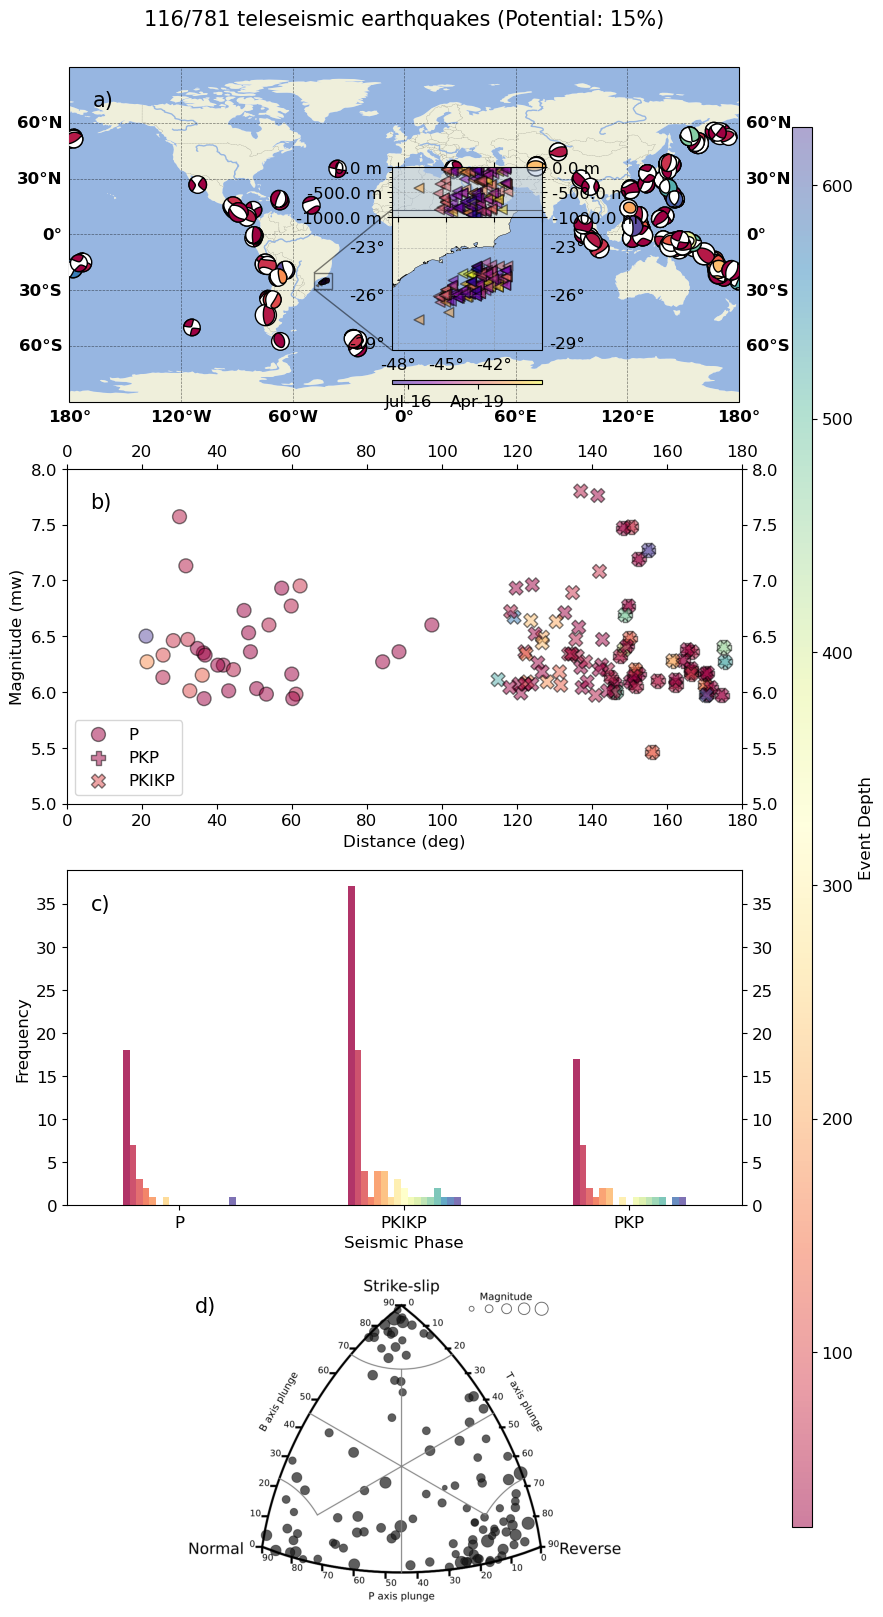

In [76]:
fig = plt.figure(figsize=(10,20))
mpl.rcParams.update({'font.size': 12})

#####################################################
# Adding MAP 
#####################################################

ax = fig.add_subplot(4,1,1,projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90])

# Normalizar valores para o intervalo [0, 1]
min_val = min(dataframe_events_glider.ev_depth_round.to_list())
max_val = max(dataframe_events_glider.ev_depth_round.to_list())
normalized_values = [(x - min_val) / (max_val - min_val) for x in dataframe_events_glider.ev_depth_round.to_list()]

# Obter as cores do colormap 'Plasma'
colors = [plt.cm.Spectral(value) for value in normalized_values]

# Converter as cores RGBA para formato hexadecimal (opcional)
hex_colors = [mcolors.rgb2hex(color) for color in colors]

for i in range(len(dataframe_events_glider['moment_tensor'])):
    bb = beach(dataframe_events_glider['moment_tensor'].values[i], xy=(dataframe_events_glider['ev_long'].values[i], dataframe_events_glider['ev_lat'].values[i]),facecolor=hex_colors[i],width=dataframe_events_glider['magnitude'].values[i]*1.5, linewidth=1)
    bb.set_zorder(10)
    ax.add_collection(bb)

ax.scatter(dataframe_events_glider['lon_glider'],dataframe_events_glider['lat_glider'],c=np.array([mdates.date2num(i) for i in dataframe_events_glider['time_glider']]),marker='<',edgecolor='k',alpha=0.5,cmap='plasma',s=2.5,transform=proj)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_ylabels = False
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
gl.xlabel_style = {'color': 'k', 'weight': 'bold'}
gl.ylabel_style = {'color': 'k', 'weight': 'bold'}
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle='--',lw=0.1)
ax.add_feature(cfeature.RIVERS)
ax.set_title(str(len(filtered_catalog))+'/'+str(len(cat))+' teleseismic earthquakes (Potential: '+str(round(len(filtered_catalog)/len(cat)*100))+'%)',fontsize=15,y=1.1)
ax.text(x=0.05,y=0.9,s='a)',ha="center", va="center",transform=ax.transAxes,fontsize=15)

#####################################################
# Adding inset 
#####################################################

axins = plt.axes([0.45, 0.69, 0.15, 0.15],projection=proj)

h = axins.scatter(dataframe_events_glider['lon_glider'],dataframe_events_glider['lat_glider'],c=np.array([mdates.date2num(i) for i in dataframe_events_glider['time_glider']]),marker='<',edgecolor='k',alpha=0.5,cmap='plasma',s=50,transform=proj)
axins.add_feature(cfeature.LAND)
axins.add_feature(cfeature.OCEAN)
axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)

# subregion of the original image
x1 = np.min(dataframe_glider_xml['lon'])-abs(np.min(dataframe_glider_xml['lon'])/30)
x2 = np.max(dataframe_glider_xml['lon'])+abs(np.max(dataframe_glider_xml['lon'])/30)
y1 = np.min(dataframe_glider_xml['lat'])-abs(np.min(dataframe_glider_xml['lat'])/30)
y2 = np.max(dataframe_glider_xml['lat'])+abs(np.max(dataframe_glider_xml['lat'])/30)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# ----------------------------------------------------------------------------------------------------------
# Adding grid 
gl = axins.gridlines(crs=ccrs.PlateCarree(),draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)
gl.xlocator = FixedLocator([int(i) for i in np.linspace(x1,x2,num=4)])
gl.ylocator = FixedLocator([int(i) for i in np.linspace(y1,y2,num=4)])
gl.xformatter = LongitudeFormatter(direction_label=False)
gl.yformatter = LatitudeFormatter(direction_label=False)

#####################################################
# Adding inset DEPTH
#####################################################

ax_histx = plt.axes([0.45, 0.805, 0.15, 0.025],sharex=axins,facecolor='lightsteelblue')
ax_histx.scatter(dataframe_events_glider['lon_glider'],dataframe_events_glider['dep_glider'],c=np.array([mdates.date2num(i) for i in dataframe_events_glider['time_glider']]),marker='<',edgecolor='k',alpha=0.5,cmap='plasma',s=50)
ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
ax_histx.set_ylim(-1000,0)
ax_histx.set_xlim(x1, x2)
ax_histx.set_xticks([int(i) for i in np.linspace(x1,x2,num=4)])
ax_histx.yaxis.set_major_formatter('{x} m')
ax_histx.yaxis.set_major_locator(MultipleLocator(500))
ax_histx.yaxis.set_minor_locator(MultipleLocator(100))
ax_histx.patch.set_alpha(0.5)

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(axins)
ax_cb = divider.append_axes("bottom",size="3%", pad=0.3, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb,orientation="horizontal")
cb.ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

ax.indicate_inset_zoom(axins, edgecolor="black")

#####################################################
# Adding SCATTER PLOT 
#####################################################

ax1 = fig.add_subplot(4, 1, 2)

P_df = dataframe_events_glider[dataframe_events_glider.Phase == "P"]
PKP_df = dataframe_events_glider[dataframe_events_glider.Phase == "PKP"]
PKIKP_df = dataframe_events_glider[dataframe_events_glider.Phase == "PKIKP"]

sc1 = ax1.scatter(P_df.distance,P_df.magnitude,marker='o',c=P_df.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),s=100,cmap='Spectral',edgecolors='k',alpha=0.5)
sc2 = ax1.scatter(PKP_df.distance,PKP_df.magnitude,marker='P',c=PKP_df.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),s=100,cmap='Spectral',edgecolors='k',alpha=0.5)
sc3 = ax1.scatter(PKIKP_df.distance,PKIKP_df.magnitude,marker='X',c=PKIKP_df.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),s=100,cmap='Spectral',edgecolors='k',alpha=0.5)

sc = [sc1,sc2,sc3]
ax1.legend(sc,["P","PKP","PKIKP"], loc='lower left',scatterpoints=1)

ax1.set_xlim(0,180)
ax1.set_ylim(5,8)
ax1.set_xlabel('Distance (deg)')
ax1.set_ylabel('Magnitude (mw)')
ax1.tick_params(axis='both',labelbottom=True, labeltop=True, labelleft=True, labelright=True,bottom=True, top=True, left=True, right=True)
ax1.text(x=0.05,y=0.9,s='b)',ha="center", va="center",transform=ax1.transAxes,fontsize=15)

#####################################################
# Adding HISTOGRAM PLOT 
#####################################################

ax2 = fig.add_subplot(4, 1, 3)
sc4 = pd.crosstab(dataframe_events_glider.Phase, dataframe_events_glider.ev_depth_round).plot.bar(stacked=False,cmap='Spectral',alpha=0.8,ax=ax2,legend=False)
ax2.set_xlabel('Seismic Phase')
ax2.set_ylabel('Frequency')
ax2.tick_params(axis='x', rotation=0, labelbottom=True, labeltop=False, labelleft=True, labelright=True,bottom=True, top=False, left=True, right=True)
ax2.tick_params(axis='y', labelbottom=True, labeltop=False, labelleft=True, labelright=True,bottom=True, top=False, left=True, right=True)
ax2.text(x=0.05,y=0.9,s='c)',ha="center", va="center",transform=ax2.transAxes,fontsize=15)

#####################################################
# Adding FOCAL MECHANISM PLOT 
#####################################################

from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
ax3 = fig.add_subplot(4, 1, 4)
arr_img = plt.imread(FOLDER_OUTPUT+'FIGURAS/STATISTICS/glider_earthquakes_focal_mechanisms_potential.png')
ax3.imshow(arr_img)
ax3.axis('off')
ax3.text(x=0.05,y=0.9,s='d)',ha="center", va="center",transform=ax3.transAxes,fontsize=15)

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(sc2, cax=cbar_ax,label='Event Depth',fraction=0.025, shrink= 0.025)

# -------------------------------------------------------------------------------------------------------------------------------------------
fig.savefig(FOLDER_OUTPUT+'FIGURAS/STATISTICS/database_earthquake_potential.png',pad_inches=0.025)


# Filtrando o banco de dados em função da análise visual dos resultados:

In [58]:
selected_events = glob.glob(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_TELESEISMIC_DETECTION_SELECTED_FINAL/*/*/*')

In [59]:
selected_events_lst = []
selected_events_lst_phase = [] 
selected_events_lst_all = [] 
for img in selected_events:
    selected_events_lst.append(img.split('/')[-1].split('.')[0].split('_')[-3])
    selected_events_lst_phase.append(img.split('/')[-1].split('.')[0].split('_')[4])
    selected_events_lst_all.append([img.split('/')[-1].split('.')[0].split('_')[4],img.split('/')[-1].split('.')[0].split('_')[-3]])

In [60]:
selected_events_lst_all

[['P', '201706140729A'],
 ['P', '201704150819A'],
 ['P', '201801140918A'],
 ['P', '201611041620A'],
 ['PKP', '201810131110A'],
 ['PKP', '201907140910A'],
 ['PKP', '201907111708A'],
 ['PKP', '201802251744A'],
 ['PKP', '202003250249A'],
 ['PKP', '201701100613A'],
 ['PKP', '201902171435A'],
 ['PKIKP', '201802251744A'],
 ['PKIKP', '201802061550A'],
 ['PKIKP', '202003250249A'],
 ['PKIKP', '201902171435A'],
 ['PKIKP', '201907111708A'],
 ['PKIKP', '201903081506A'],
 ['PKIKP', '201907140910A'],
 ['PKIKP', '201612081738A']]

In [61]:
selected_events_lst = list(set(selected_events_lst))

In [62]:
len(selected_events_lst)

14

In [63]:
final_catalog = []
for i in selected_events_lst:
    for j in filtered_catalog:
        if i == j.event_descriptions[0].text:
            final_catalog.append(j)

In [64]:
# Obtaining all the parameters from the moment tensor via FMC.py
results_final_lst = []
for evet in final_catalog:
    Exponent_ = 1
    results_final_lst.append(str(evet.origins[0].longitude)+' '+str(evet.origins[0].latitude)+' '+str(evet.origins[0].depth/1000)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rr)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_tt)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_pp)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rt)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_rp)+' '
      +str(evet.focal_mechanisms[0].moment_tensor.tensor.m_tp)+' '
      +str(Exponent_)+' '+' X Y '+evet.event_descriptions[0].text)

In [65]:
file = open('earthquakes_glider_final.dat','w')
for item in results_final_lst:
	file.write(item+"\n")
file.close()

In [66]:
os.system('python FMC.py -p '+FOLDER_OUTPUT+'FIGURAS/STATISTICS/Glider_final_data.pdf earthquakes_glider_final.dat')

#Longitude Latitude Depth_(km) mrr mtt mff mrt mrf mtf Exponent_(dyn-cm) X_position(GMT) Y_position(GMT) ID rupture_type
-92.17 14.92 72.7 -1.48 0.845 0.631 2.25 -1.83 -1.1 20.0 X Y 201706140729A N
122.78 4.57 621.5 -0.073 0.143 -0.07 0.071 -0.966 0.27 21.0 X Y 201701100613A N
-74.78 -15.95 40.9 5.57 -3.12 -2.44 0.76 -1.53 3.39 20.0 X Y 201801140918A R
161.12 -10.46 45.5 5.22 -3.57 -1.65 -1.35 -1.86 3.69 21.0 X Y 201612081738A R-SS
153.43 52.71 473.4 -0.543 0.25 0.293 -0.093 -0.907 -0.885 20.0 X Y 201810131110A N-SS
128.13 -0.72 12.0 -0.72 7.35 -6.64 0.59 0.58 2.83 20.0 X Y 201907140910A SS
155.19 -4.66 493.1 -1.11 1.16 -0.054 0.386 -0.21 0.303 19.0 X Y 201907111708A N
157.87 49.11 52.6 1.96 -0.199 -1.76 0.189 -0.293 -0.815 21.0 X Y 202003250249A R
121.54 24.0 13.9 2.45 -4.25 1.8 1.44 -0.594 -2.54 19.0 X Y 201802061550A SS-R
152.13 -3.33 372.2 -4.72 3.88 0.837 1.65 -0.223 0.757 19.0 X Y 201902171435A N
142.97 -6.29 12.0 1.69 -1.29 -0.4 1.13 -0.255 0.7 21.0 X Y 201802251744A R
-67.92 -2

0

In [67]:
selected_events_lst_all

[['P', '201706140729A'],
 ['P', '201704150819A'],
 ['P', '201801140918A'],
 ['P', '201611041620A'],
 ['PKP', '201810131110A'],
 ['PKP', '201907140910A'],
 ['PKP', '201907111708A'],
 ['PKP', '201802251744A'],
 ['PKP', '202003250249A'],
 ['PKP', '201701100613A'],
 ['PKP', '201902171435A'],
 ['PKIKP', '201802251744A'],
 ['PKIKP', '201802061550A'],
 ['PKIKP', '202003250249A'],
 ['PKIKP', '201902171435A'],
 ['PKIKP', '201907111708A'],
 ['PKIKP', '201903081506A'],
 ['PKIKP', '201907140910A'],
 ['PKIKP', '201612081738A']]

In [77]:
df_sel = []
for i,j in enumerate(selected_events_lst_all):
    dataframe_events_glider_final = dataframe_events_glider[(dataframe_events_glider['ev_ID'] == j[1]) & (dataframe_events_glider['Phase'] == j[0])]
    df_sel.append(dataframe_events_glider_final)

In [78]:
len(df_sel)

19

In [79]:
dataframe_events_glider_final = pd.concat(df_sel, ignore_index=True)

In [80]:
len(dataframe_events_glider_final)

19

In [81]:
dataframe_events_glider_final.sort_values('distance')

,filename_mseed,name_glider,Phase,ev_ID,ev_time,ev_lat,ev_long,ev_depth,distance,magnitude,...,lat_dive_info,lon_dive_info,depth_dive_info,srn_per_band,sta_lta_max_per_band,noise_per_band,automatic_event_detection,automatic_time_residual,year,ev_depth_round
1,GL.G170B..HHH.D.2017.105,G170B,P,201704150819A,2017-04-15T08:19:48.300000Z,-23.2,-67.92,164.2,21.404124,6.27,...,"[-25.06429, -25.064194, -25.064098, -25.064003...","[-44.576466, -44.57627, -44.576073, -44.575874...","[-348.46002, -355.0655, -361.505, -367.351, -3...","[1.8, 1.0, 1.0, 1.1, 4.2, 4.7]","[4.081472549707962, 1.6518214055124516, 1.9778...","[-41.64898035233148, -48.86660614126883, -44.2...",True,-3.42,2017,175.0
3,GL.G1607..HHH.D.2016.309,G1607,P,201611041620A,2016-11-04T16:20:49.900000Z,-35.06,-70.98,96.2,25.685713,6.33,...,"[-25.949436, -25.949436, -25.949442, -25.94944...","[-43.015472, -43.015476, -43.015606, -43.01561...","[-3.3246875, -4.046562, -15.369532, -15.788984...","[1.0, 0.9, 1.0, 1.1, 1.9, 1.9]","[2.1434356926271656, 2.2520709464428994, 2.260...","[-38.042218338530354, -41.85597469926445, -40....",True,1.87,2016,100.0
2,GL.G170J..HHH.D.2018.014,G170J,P,201801140918A,2018-01-14T09:18:52.300000Z,-15.95,-74.78,40.9,31.757713,7.13,...,"[-24.461828, -24.461918, -24.462008, -24.46209...","[-42.119774, -42.119724, -42.11967, -42.11962,...","[-1.922, -7.8412, -17.2975, -26.527, -35.572, ...","[1.1, 1.0, 1.0, 1.2, 1.3, 1.5]","[3.0047245602623196, 3.356527592065594, 4.0751...","[-37.3817707769603, -42.56528070368033, -39.98...",True,1.27,2018,50.0
0,GL.G170E..HHH.D.2017.165,G170E,P,201706140729A,2017-06-14T07:29:07.900000Z,14.92,-92.17,72.7,62.215434,6.95,...,"[-26.007275, -26.007362, -26.007454, -26.00754...","[-43.86434, -43.8644, -43.864456, -43.86451, -...","[-1.85, -4.1899996, -12.424999, -19.012001, -2...","[1.7, 1.0, 0.9, 1.0, 1.6, 3.7]","[6.505769784624672, 3.2188930134934375, 2.8289...","[-40.090801396433974, -49.12575636090834, -43....",True,-3.8,2017,75.0
18,GL.G1608..HHH.D.2016.343,G1608,PKIKP,201612081738A,2016-12-08T17:39:00.500000Z,-10.46,161.12,45.5,137.04577,7.8,...,"[-25.51188, -25.511879, -25.511814, -25.511812...","[-43.22313, -43.223125, -43.222874, -43.22287,...","[-1.8746874, -1.9590625, -15.767813, -16.09047...","[0.7, 0.7, 0.8, 0.8, 0.4, 2.0]","[1.2534007081941485, 1.4130950699184386, 1.158...","[-36.14171685874591, -40.343914198917844, -40....",True,-7.75,2016,50.0
6,GL.G190X..HHH.D.2019.192,G190X,PKP,201907111708A,2019-07-11T17:08:38.800000Z,-4.66,155.19,493.1,146.5783,6.0,...,"[-24.835674, -24.835552, -24.83543, -24.835304...","[-41.17133, -41.17134, -41.17137, -41.171417, ...","[-187.98059, -190.62283, -193.01782, -195.2829...","[1.0, 0.9, 1.0, 0.9, 1.1, 3.2]","[3.663620077601069, 4.322916973237163, 3.28471...","[-40.96094300527167, -44.09812270571671, -44.6...",True,1.32,2019,500.0
15,GL.G190X..HHH.D.2019.192,G190X,PKIKP,201907111708A,2019-07-11T17:08:38.800000Z,-4.66,155.19,493.1,146.5783,6.0,...,"[-24.835674, -24.835552, -24.83543, -24.835304...","[-41.17133, -41.17134, -41.17137, -41.171417, ...","[-187.98059, -190.62283, -193.01782, -195.2829...","[1.0, 1.0, 1.0, 0.9, 1.1, 3.1]","[3.5540073285922893, 4.171467921392718, 3.1904...","[-41.56527534921486, -44.99504218162498, -45.0...",True,3.82,2019,500.0
7,GL.G180L..HHH.D.2018.056,G180L,PKP,201802251744A,2018-02-25T17:45:08.600000Z,-6.29,142.97,12.0,148.417358,7.47,...,"[-24.97619, -24.976212, -24.976233, -24.976252...","[-42.043636, -42.043568, -42.04349, -42.04342,...","[-191.01999, -196.92047, -202.87401, -208.7938...","[1.0, 0.9, 0.9, 0.8, 1.7, 3.0]","[3.7645678417850137, 2.8641628480536543, 4.044...","[-37.63808104127702, -44.99123840492537, -40.3...",True,-3.49,2018,25.0
11,GL.G180L..HHH.D.2018.056,G180L,PKIKP,201802251744A,2018-02-25T17:45:08.600000Z,-6.29,142.97,12.0,148.417358,7.47,...,"[-24.97619, -24.976212, -24.976233, -24.976252...","[-42.043636, -42.043568, -42.04349, -42.04342,...","[-191.01999, -196.92047, -202.87401, -208.7938...","[1.1, 1.0, 1.0, 1.1, 1.5, 

In [82]:
dataframe_events_glider_final['automatic_event_detection'] = dataframe_events_glider_final['automatic_event_detection'].astype(bool)

In [83]:
dataframe_events_glider_final['manual_event_detection'] = ~dataframe_events_glider_final['automatic_event_detection']


In [84]:
dataframe_events_glider_final.to_csv(FOLDER_OUTPUT+'FIGURAS/STATISTICS/table_events_selected.csv')

# FIGURA FINAL com terremotos, análises estatísticas e análise do mecanismo focal

In [85]:
event_local = obspy.read_events(QUAKEXML_FOLDER+'event_2020_03_25_brazil.xml')

/home/sysop/Programs/miniconda3/lib/python3.11/site-packages/obspy/imaging/beachball.py:190: UserWarning: There is a known bug when plotting semi-transparent patches for non-DC sources, which leads to blending of pressure and tension color, see issue #1464.
  warnings.warn(msg)
/tmp/ipykernel_51565/2596111971.py:131: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_xticklabels(cb.ax.get_xticklabels(), rotation=45)


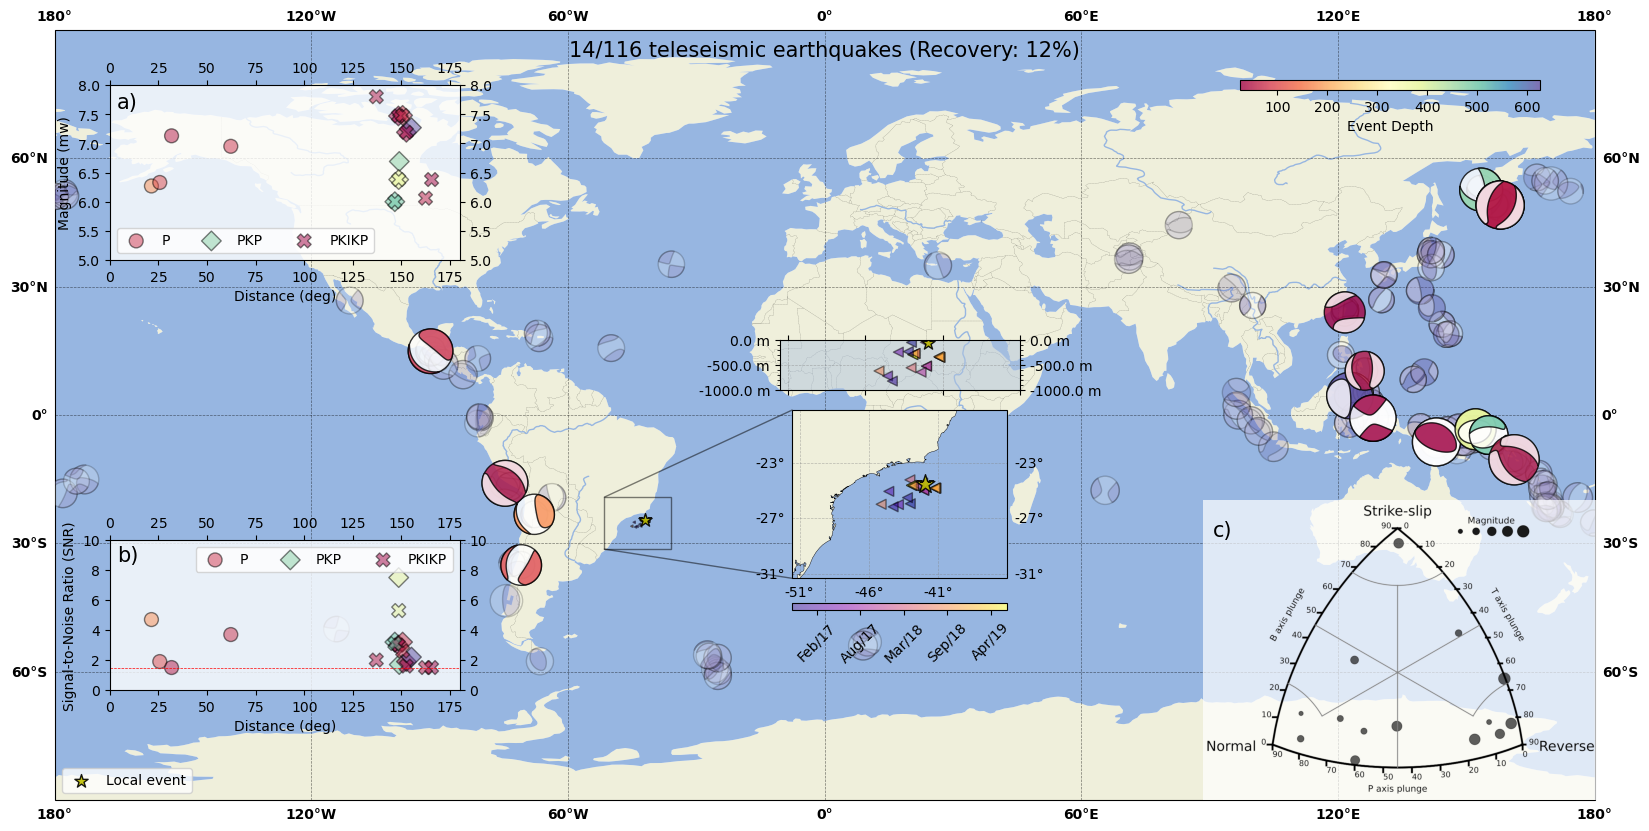

In [89]:
fig = plt.figure(figsize=(20,10))
# Definindo globalmente o tamanho da fonte
mpl.rcParams.update({'font.size': 10})

#####################################################
# Adding MAP 
#####################################################

ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())

ax.set_extent([-180, 180, -90, 90])


# Normalizar valores para o intervalo [0, 1]
min_val = min(dataframe_events_glider.ev_depth_round.to_list())
max_val = max(dataframe_events_glider.ev_depth_round.to_list())
normalized_values = [(x - min_val) / (max_val - min_val) for x in dataframe_events_glider.ev_depth_round.to_list()]

# Obter as cores do colormap 'Plasma'
colors = [plt.cm.Spectral(value) for value in dataframe_events_glider.ev_depth_round.to_list()]

# Converter as cores RGBA para formato hexadecimal (opcional)
hex_colors = [mcolors.rgb2hex(color) for color in colors]

for i in range(len(dataframe_events_glider['moment_tensor'])):
    bb = beach(dataframe_events_glider['moment_tensor'].values[i], xy=(dataframe_events_glider['ev_long'].values[i], dataframe_events_glider['ev_lat'].values[i]),facecolor=hex_colors[i],width=dataframe_events_glider['magnitude'].values[i],alpha=0.2, linewidth=1)
    bb.set_zorder(10)
    ax.add_collection(bb)


# -----------------------------------------------------------------------------------------------------------------------------------------
# FINAL DATAFRAME

# Normalize event depth values between max and min event depth (km):
min_val = min(dataframe_events_glider.ev_depth_round.to_list())
max_val = max(dataframe_events_glider.ev_depth_round.to_list())
normalized_values = [(x - min_val) / (max_val - min_val) for x in dataframe_events_glider.ev_depth_round.to_list()]

# Colormap "Plasma" for each value
colors = [plt.cm.Spectral(value) for value in normalized_values]
                                                                        
# Convert colors RGB to hexadecimal:
hex_colors = [mcolors.rgb2hex(color) for color in colors]

for i in range(len(dataframe_events_glider_final['moment_tensor'])):
    # Find the color for a given depth
    diff_ev_depth = [np.abs(numero - dataframe_events_glider_final['ev_depth'][i]) for numero in dataframe_events_glider.ev_depth_round.to_list()]
                                            
    # Find the min index for a given depth
    index_min_ev_depth = diff_ev_depth.index(min(diff_ev_depth))
    
    bb = beach(dataframe_events_glider_final['moment_tensor'].values[i], xy=(dataframe_events_glider_final['ev_long'].values[i], dataframe_events_glider_final['ev_lat'].values[i]),facecolor=hex_colors[index_min_ev_depth],width=dataframe_events_glider_final['magnitude'].values[i]*1.5,alpha=0.8, linewidth=1)
    bb.set_zorder(10)
    ax.add_collection(bb)

ax.scatter(dataframe_events_glider_final['lon_glider'],dataframe_events_glider_final['lat_glider'],c=np.array([mdates.date2num(i) for i in dataframe_events_glider_final['time_glider']]),marker='<',edgecolor='k',alpha=0.5,cmap='plasma',s=2.5,transform=proj)
ax.scatter(event_local[0].origins[-1].longitude,event_local[0].origins[-1].latitude,c="y",marker='*',edgecolor='k',alpha=0.9,s=100,transform=proj,label='Local event')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.5, linestyle='--')
gl.top_xlabels = False
gl.left_ylabels = False
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
gl.xlabel_style = {'color': 'k', 'weight': 'bold'}
gl.ylabel_style = {'color': 'k', 'weight': 'bold'}
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle='--',lw=0.1)
ax.add_feature(cfeature.RIVERS)
ax.set_title(str(len(selected_events_lst))+'/'+str(len(filtered_catalog))+' teleseismic earthquakes (Recovery: '+str(round(len(selected_events_lst)/len(filtered_catalog)*100))+'%)',fontsize=15,y=0.955)
ax.legend(loc='lower left')

#####################################################
# Adding inset GLIDER LOC
#####################################################

axins = plt.axes([0.45, 0.3, 0.20, 0.20],projection=proj)

h = axins.scatter(dataframe_events_glider_final['lon_glider'],dataframe_events_glider_final['lat_glider'],c=np.array([mdates.date2num(i) for i in dataframe_events_glider_final['time_glider']]),marker='<',edgecolor='k',alpha=0.5,cmap='plasma',s=50,transform=proj)
axins.scatter(event_local[0].origins[-1].longitude,event_local[0].origins[-1].latitude,c="y",marker='*',edgecolor='k',alpha=0.9,s=200,transform=proj)

axins.add_feature(cfeature.LAND)
axins.add_feature(cfeature.OCEAN)
axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)

# subregion of the original image
x1 = np.min(dataframe_glider_xml['lon'])-abs(np.min(dataframe_glider_xml['lon'])/10)
x2 = np.max(dataframe_glider_xml['lon'])+abs(np.max(dataframe_glider_xml['lon'])/10)
y1 = np.min(dataframe_glider_xml['lat'])-abs(np.min(dataframe_glider_xml['lat'])/10)
y2 = np.max(dataframe_glider_xml['lat'])+abs(np.max(dataframe_glider_xml['lat'])/10)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# ----------------------------------------------------------------------------------------------------------
# Adding grid 
gl = axins.gridlines(crs=ccrs.PlateCarree(),draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)
gl.xlocator = FixedLocator([int(i) for i in np.linspace(x1,x2,num=4)])
gl.ylocator = FixedLocator([int(i) for i in np.linspace(y1,y2,num=4)])
gl.xformatter = LongitudeFormatter(direction_label=False)
gl.yformatter = LatitudeFormatter(direction_label=False)

#####################################################
# Adding inset GLIDER DEPTH
#####################################################

ax_histx = plt.axes([0.49, 0.52, 0.12, 0.05],sharex=axins,facecolor='lightsteelblue')
ax_histx.scatter(dataframe_events_glider_final['lon_glider'],dataframe_events_glider_final['dep_glider'],c=np.array([mdates.date2num(i) for i in dataframe_events_glider_final['time_glider']]),marker='<',edgecolor='k',alpha=0.5,cmap='plasma',s=50)
ax_histx.scatter(event_local[0].origins[-1].longitude,-50,c="y",marker='*',edgecolor='k',alpha=0.9,s=100)

ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
ax_histx.set_ylim(-1000,0)
ax_histx.set_xlim(x1, x2)
ax_histx.set_xticks([int(i) for i in np.linspace(x1,x2,num=4)])
ax_histx.yaxis.set_major_formatter('{x} m')
ax_histx.yaxis.set_major_locator(MultipleLocator(500))
ax_histx.yaxis.set_minor_locator(MultipleLocator(100))
ax_histx.patch.set_alpha(0.5)

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(axins)
ax_cb = divider.append_axes("bottom",size="4%", pad=0.25, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb,orientation="horizontal")
cb.ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))
cb.ax.set_xticklabels(cb.ax.get_xticklabels(), rotation=45)

ax.indicate_inset_zoom(axins, edgecolor="black")

#####################################################
# Adding SCATTER PLOT FINAL (MAG)
#####################################################

ax1 = plt.axes([0.155, 0.65, 0.175, 0.175])

# AUTOMATIC DETECTION
P_df_auto = dataframe_events_glider_final[(dataframe_events_glider_final.Phase == 'P') & (dataframe_events_glider_final.automatic_event_detection == True)]
PKP_df_auto = dataframe_events_glider_final[(dataframe_events_glider_final.Phase == 'PKP') & (dataframe_events_glider_final.automatic_event_detection == True)]
PKIKP_df_auto = dataframe_events_glider_final[(dataframe_events_glider_final.Phase == 'PKIKP') & (dataframe_events_glider_final.automatic_event_detection == True)]

sc1_auto = ax1.scatter(P_df_auto.distance,P_df_auto.magnitude,marker='o',c=P_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),s=100,cmap='Spectral',edgecolors='k',alpha=0.5,linewidth=1,ls='-')
sc2_auto = ax1.scatter(PKP_df_auto.distance,PKP_df_auto.magnitude,marker='D',c=PKP_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),s=100,cmap='Spectral',edgecolors='k',alpha=0.5,linewidth=1,ls='-')
sc3_auto = ax1.scatter(PKIKP_df_auto.distance,PKIKP_df_auto.magnitude,marker='X',c=PKIKP_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),s=100,cmap='Spectral',edgecolors='k',alpha=0.5,linewidth=1,ls='-')
sc_auto = [sc1_auto,sc2_auto,sc3_auto]

ax1.legend(sc_auto,["P","PKP","PKIKP"], loc='lower left',scatterpoints=1,ncols=4)

ax1.set_xlim(0,180)
ax1.set_ylim(5,8)
ax1.set_xlabel('Distance (deg)')
ax1.set_ylabel('Magnitude (mw)')
ax1.tick_params(axis='both',labelbottom=True, labeltop=True, labelleft=True, labelright=True,bottom=True, top=True, left=True, right=True)
ax1.text(x=0.05,y=0.9,s='a)',ha="center", va="center",transform=ax1.transAxes,fontsize=15)
ax1.patch.set_alpha(0.8)

#####################################################
# Adding SCATTER PLOT FINAL (SNR)
#####################################################

ax2 = plt.axes([0.155, 0.22, 0.175, 0.15])

sc1_auto = ax2.scatter(P_df_auto.distance,[(i[-1]) for i in P_df_auto.srn_per_band.to_list()],marker='o',c=P_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),s=100,cmap='Spectral',edgecolors='k',alpha=0.5,linewidth=1,ls='-')
sc2_auto = ax2.scatter(PKP_df_auto.distance,[(i[-1]) for i in PKP_df_auto.srn_per_band.to_list()],marker='D',c=PKP_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),s=100,cmap='Spectral',edgecolors='k',alpha=0.5,linewidth=1,ls='-')
sc3_auto = ax2.scatter(PKIKP_df_auto.distance,[(i[-1]) for i in PKIKP_df_auto.srn_per_band.to_list()],marker='X',c=PKIKP_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),s=100,cmap='Spectral',edgecolors='k',alpha=0.5,linewidth=1,ls='-')
sc_auto = [sc1_auto,sc2_auto,sc3_auto]

ax2.legend(sc_auto,["P","PKP","PKIKP"], loc='upper right',scatterpoints=1,ncols=4)

ax2.axhline(xmin=0,xmax=1, y=1.5, color='r',lw=0.5,linestyle='--')

ax2.set_xlim(0,180)
ax2.set_ylim(0,10)
ax2.set_xlabel('Distance (deg)')
ax2.set_ylabel('Signal-to-Noise Ratio (SNR)')
ax2.tick_params(axis='both',labelbottom=True, labeltop=True, labelleft=True, labelright=True,bottom=True, top=True, left=True, right=True)
ax2.text(x=0.05,y=0.9,s='b)',ha="center", va="center",transform=ax2.transAxes,fontsize=15)
ax2.patch.set_alpha(0.8)

#####################################################
# Adding FOCAL MECHANISM PLOT 
#####################################################

ax3 = plt.axes([0.65, 0.11, 0.3, 0.3])
arr_img = plt.imread(FOLDER_OUTPUT+'FIGURAS/STATISTICS/glider_earthquakes_focal_mechanisms.png')
ax3.imshow(arr_img)
ax3.axis('off')
ax3.text(x=0.05,y=0.9,s='c)',ha="center", va="center",transform=ax3.transAxes,fontsize=15)

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
cbar_ax = fig.add_axes([0.72, 0.82, 0.15, 0.01])
cbar = fig.colorbar(sc2, cax=cbar_ax,label='Event Depth',orientation='horizontal')
# -------------------------------------------------------------------------------------------------------------------------------------------
os.makedirs(FOLDER_OUTPUT+'FIGURAS/STATISTICS/',exist_ok=True)
fig.savefig(FOLDER_OUTPUT+'FIGURAS/STATISTICS/database_earthquake_recorded.png',pad_inches=0.0,dpi=200)


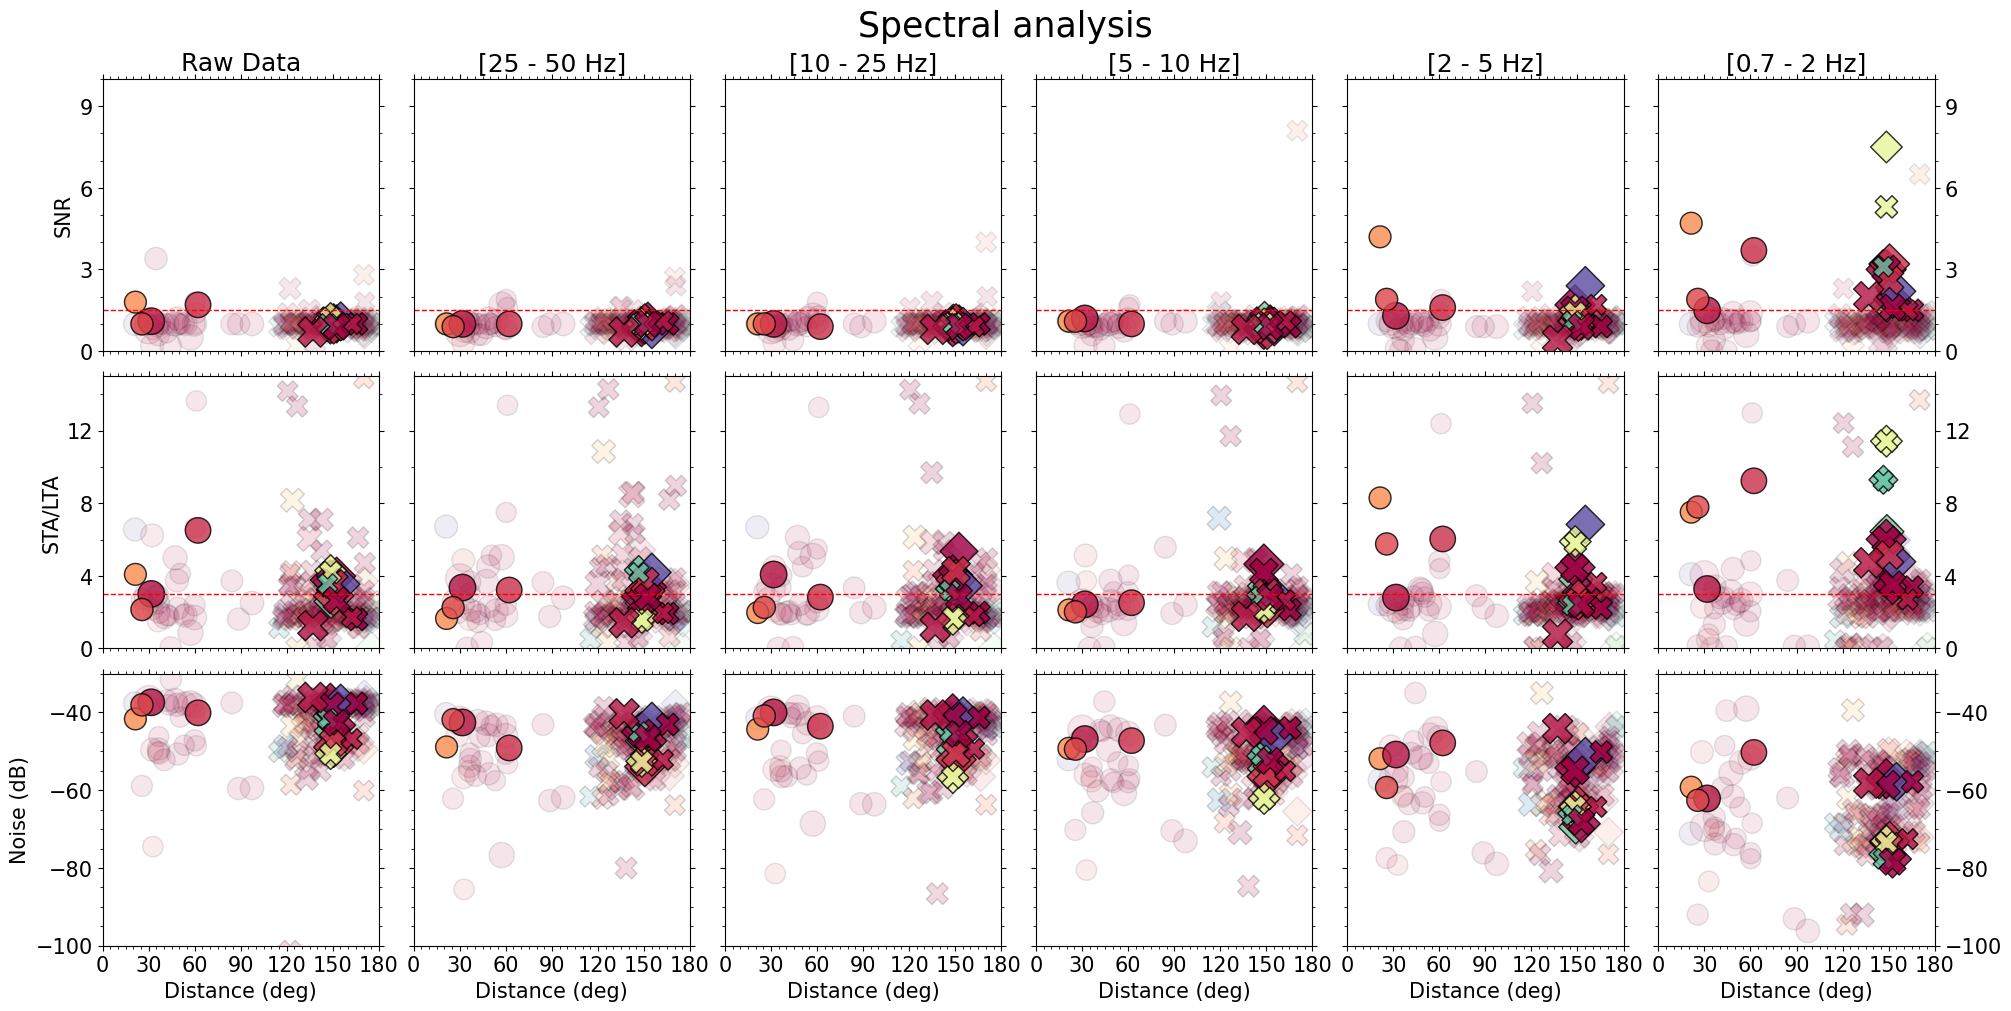

In [91]:
fig = plt.figure(constrained_layout=True,figsize=(20,10))
mpl.rcParams.update({'font.size': 15})
                                    

spec = gridspec.GridSpec(ncols=6, nrows=3, figure=fig)
        
fig.suptitle('Spectral analysis',fontsize=25)

filter_class = [['Raw Data'],[25,50],[10,25],[5,10],[2,5],[0.7,2]]


for k,l in enumerate(filter_class):
        
        ##################
        # SCATTER PLOT SRN
        ##################

        # axes
        ax1 = fig.add_subplot(spec[0,k])
        ax2 = fig.add_subplot(spec[1,k], sharex=ax1)
        ax3 = fig.add_subplot(spec[2,k],sharex=ax2)
        
        # -------------------------------
        # Adding SCATTER PLOT SNR (TOTAL)
    
        if k == 0:
            ax1.set_title(str(l[0]))
            ax1.set_ylabel('SNR')
            ax1.tick_params(axis='both',labelbottom=False, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)

            ax2.set_ylabel('STA/LTA')
            ax2.tick_params(axis='both',labelbottom=False, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)

            ax3.set_ylabel('Noise (dB)')
            ax3.tick_params(axis='both',labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)
              
        elif k == len(filter_class)-1:
            ax1.set_title('['+str(l[0])+' - '+str(l[1])+' Hz]')
            ax1.tick_params(axis='both',labelbottom=False, labeltop=False, labelleft=False, labelright=True, bottom=True, top=True, left=True, right=True)
            ax2.tick_params(axis='both',labelbottom=False, labeltop=False, labelleft=False, labelright=True, bottom=True, top=True, left=True, right=True)
            ax3.tick_params(axis='both',labelbottom=True, labeltop=False, labelleft=False, labelright=True, bottom=True, top=True, left=True, right=True)
 
        else:
            ax1.set_title('['+str(l[0])+' - '+str(l[1])+' Hz]')
            ax1.tick_params(axis='both',labelbottom=False, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)
            ax2.tick_params(axis='both',labelbottom=False, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)
            ax3.tick_params(axis='both',labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)
 
                          
        P_df_total = dataframe_events_glider[dataframe_events_glider.Phase == "P"]
        PKP_df_total = dataframe_events_glider[dataframe_events_glider.Phase == "PKP"]
        PKIKP_df_total = dataframe_events_glider[dataframe_events_glider.Phase == "PKIKP"]
        
        sc1 = ax1.scatter(P_df_total.distance,[(i[k]) for i in P_df_total.srn_per_band.to_list()],marker='o',s=[i**3 for i in P_df_total.magnitude.to_list()],c=P_df_total.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.1)
        sc2 = ax1.scatter(PKP_df_total.distance,[(i[k]) for i in PKP_df_total.srn_per_band.to_list()],marker='D',s=[i**3 for i in PKP_df_total.magnitude.to_list()],c=PKP_df_total.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.1)
        sc3 = ax1.scatter(PKIKP_df_total.distance,[(i[k]) for i in PKIKP_df_total.srn_per_band.to_list()],marker='X',s=[i**3 for i in PKIKP_df_total.magnitude.to_list()],c=PKIKP_df_total.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.1)
        
        # ----------------------------------
        # Adding SCATTER PLOT SNR (SELECTED)
        
        P_df_auto = dataframe_events_glider_final[(dataframe_events_glider_final.Phase == 'P') & (dataframe_events_glider_final.automatic_event_detection == True)]
        PKP_df_auto = dataframe_events_glider_final[(dataframe_events_glider_final.Phase == 'PKP') & (dataframe_events_glider_final.automatic_event_detection == True)]
        PKIKP_df_auto = dataframe_events_glider_final[(dataframe_events_glider_final.Phase == 'PKIKP') & (dataframe_events_glider_final.automatic_event_detection == True)]
        
        sc1 = ax1.scatter(P_df_auto.distance,[(i[k]) for i in P_df_auto.srn_per_band.to_list()],marker='o',s=[i**3 for i in P_df_auto.magnitude.to_list()],c=P_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.8,linewidth=1,ls='-')
        sc2 = ax1.scatter(PKP_df_auto.distance,[(i[k]) for i in PKP_df_auto.srn_per_band.to_list()],marker='D',s=[i**3 for i in PKP_df_auto.magnitude.to_list()],c=PKP_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.8,linewidth=1,ls='-')
        sc3 = ax1.scatter(PKIKP_df_auto.distance,[(i[k]) for i in PKIKP_df_auto.srn_per_band.to_list()],marker='X',s=[i**3 for i in PKIKP_df_auto.magnitude.to_list()],c=PKIKP_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.8,linewidth=1,ls='-')
        
        ax1.axhline(xmin=0,xmax=1, y=1.5, color='r',lw=1,linestyle='--')
        ax1.xaxis.set_major_locator(MultipleLocator(60))
        ax1.xaxis.set_minor_locator(MultipleLocator(5))
        ax1.xaxis.set_ticks_position('both')
        
        ax1.yaxis.set_major_locator(MultipleLocator(3))
        ax1.yaxis.set_minor_locator(MultipleLocator(1))
        ax1.yaxis.set_ticks_position('both')
        
        ax1.set_xlim(0,180)
        ax1.set_ylim(0,10)        
        
        ############################
        # SCATTER PLOT STA/LTA RATIO
        ############################
        
        # -----------------------------------------
        # Adding SCATTER PLOT STA/LTA RATIO (TOTAL)
        
        sc1 = ax2.scatter(P_df_total.distance,[(i[k]) for i in P_df_total.sta_lta_max_per_band.to_list()],marker='o',s=[i**3 for i in P_df_total.magnitude.to_list()],c=P_df_total.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.1)
        sc2 = ax2.scatter(PKP_df_total.distance,[(i[k]) for i in PKP_df_total.sta_lta_max_per_band.to_list()],marker='D',s=[i**3 for i in PKP_df_total.magnitude.to_list()],c=PKP_df_total.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.1)
        sc3 = ax2.scatter(PKIKP_df_total.distance,[(i[k]) for i in PKIKP_df_total.sta_lta_max_per_band.to_list()],marker='X',s=[i**3 for i in PKIKP_df_total.magnitude.to_list()],c=PKIKP_df_total.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.17)
        
        # --------------------------------------------
        # Adding SCATTER PLOT STA/LTA RATIO (SELECTED)
              
        sc1 = ax2.scatter(P_df_auto.distance,[(i[k]) for i in P_df_auto.sta_lta_max_per_band.to_list()],marker='o',s=[i**3 for i in P_df_auto.magnitude.to_list()],c=P_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.8,linewidth=1,ls='-')
        sc2 = ax2.scatter(PKP_df_auto.distance,[(i[k]) for i in PKP_df_auto.sta_lta_max_per_band.to_list()],marker='D',s=[i**3 for i in PKP_df_auto.magnitude.to_list()],c=PKP_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.8,linewidth=1,ls='-')
        sc3 = ax2.scatter(PKIKP_df_auto.distance,[(i[k]) for i in PKIKP_df_auto.sta_lta_max_per_band.to_list()],marker='X',s=[i**3 for i in PKIKP_df_auto.magnitude.to_list()],c=PKIKP_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.8,linewidth=1,ls='-')
        
        ax2.axhline(xmin=0,xmax=1, y=3, color='r',lw=1,linestyle='--')
        
        ax2.xaxis.set_major_locator(MultipleLocator(60))
        ax2.xaxis.set_minor_locator(MultipleLocator(5))
        ax2.xaxis.set_ticks_position('both')
        
        ax2.yaxis.set_major_locator(MultipleLocator(4))
        ax2.yaxis.set_minor_locator(MultipleLocator(2))
        ax2.yaxis.set_ticks_position('both')
        
        ax2.set_xlim(0,180)
        ax2.set_ylim(0,15)
                    
        #########################
        # SCATTER PLOT NOISE (dB)
        #########################
        
        # ------------------------------------
        # Adding SCATTER PLOT NOISE (TOTAL)
                
        sc1 = ax3.scatter(P_df_total.distance,[(i[k]) for i in P_df_total.noise_per_band.to_list()],marker='o',s=[i**3 for i in P_df_total.magnitude.to_list()],c=P_df_total.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.1)
        sc2 = ax3.scatter(PKP_df_total.distance,[(i[k]) for i in PKP_df_total.noise_per_band.to_list()],marker='D',s=[i**3 for i in PKP_df_total.magnitude.to_list()],c=PKP_df_total.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.1)
        sc3 = ax3.scatter(PKIKP_df_total.distance,[(i[k]) for i in PKIKP_df_total.noise_per_band.to_list()],marker='X',s=[i**3 for i in PKIKP_df_total.magnitude.to_list()],c=PKIKP_df_total.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.17)
        
        # ------------------------------------
        # Adding SCATTER PLOT NOISE (SELECTED)
        
        sc1 = ax3.scatter(P_df_auto.distance,[(i[k]) for i in P_df_auto.noise_per_band.to_list()],marker='o',s=[i**3 for i in P_df_auto.magnitude.to_list()],c=P_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.8,linewidth=1,ls='-')
        sc2 = ax3.scatter(PKP_df_auto.distance,[(i[k]) for i in PKP_df_auto.noise_per_band.to_list()],marker='D',s=[i**3 for i in PKP_df_auto.magnitude.to_list()],c=PKP_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.8,linewidth=1,ls='-')
        sc3 = ax3.scatter(PKIKP_df_auto.distance,[(i[k]) for i in PKIKP_df_auto.noise_per_band.to_list()],marker='X',s=[i**3 for i in PKIKP_df_auto.magnitude.to_list()],c=PKIKP_df_auto.ev_depth_round.to_list(),vmax=dataframe_events_glider.ev_depth_round.max(),vmin=dataframe_events_glider.ev_depth_round.min(),cmap='Spectral',edgecolors='k',alpha=0.8,linewidth=1,ls='-')
               
        ax3.xaxis.set_major_locator(MultipleLocator(30))
        ax3.xaxis.set_minor_locator(MultipleLocator(5))
        ax3.xaxis.set_ticks_position('both')
        
        ax3.yaxis.set_major_locator(MultipleLocator(20))
        ax3.yaxis.set_minor_locator(MultipleLocator(5))
        ax3.yaxis.set_ticks_position('both')
        
        ax3.set_xlim(0,180)
        ax3.set_ylim(-100,-30)

        ax3.set_xlabel('Distance (deg)')
    
# -------------------------------------------------------------------------------------------------------------------------------------------
os.makedirs(FOLDER_OUTPUT+'FIGURAS/STATISTICS/',exist_ok=True)
fig.savefig(FOLDER_OUTPUT+'FIGURAS/STATISTICS/database_earthquake_noise_level.png',pad_inches=0.2,dpi=200)
